# Info
Name:  

    ORACLES_AOD_profile

Purpose:  

    Comparison of AOD from 4STAR over a profile
    Additional calculations of the aerosol extinction profile
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - load_utils.py : for loading OMI HDF5 files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - pytables
    - os
    - path_utils.pu: for setting up proper paths in a cross device manner
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, OSAN AFB, Korea, 2016-05-09
    Modified: Samuel LeBlanc, Swakopmund, Namibia, 2016-09-05
              ported from KORUS
    Modified: Samuel LeBlanc, Santa Cruz, CA, 2017-11-22
              Added new plotting for the special case of 2016-09-20 and updated the data inputs

# Import the required modules and set up base


In [1]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import tables
import load_utils as lm
from path_utils import getpath
import hdf5storage as hs
import plotting_utils as pu
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fp = getpath('ORACLES')
fp

Return path named:  ORACLES /mnt/c/Users/sleblanc/Research/ORACLES/


u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [3]:
fdat = getpath('4STAR_data')
fdat = fdat[0:-1]
fdat

Return path named:  4STAR_data /mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder//


u'/mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder/'

In [4]:
from mpl_toolkits.basemap import Basemap,cm
from Sp_parameters import deriv, smooth

# Load the various data

## Load the 4STAR starsun


In [5]:
dd = '20160920'

In [6]:
f_star = fp+'data/4STAR_{}starsun.mat'.format(dd)

In [7]:
s = sio.loadmat(f_star)

In [8]:
s.keys()

['El_gnd',
 'Str',
 'tau_O3_err',
 'sza',
 'nirfilen',
 'toggle',
 'pitch',
 'Tst',
 'fwhm',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'nirheader',
 'nirdatatype',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'flagfilename',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'm_ray',
 'm_err',
 'forj_corr',
 'tau_O4_err',
 'flagallcolsitems',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'flagallcols',
 '__header__',
 'rate',
 'daystr',
 'rawrelstd',
 'program_version',
 'sat_time',
 'm_O3',
 'tau_aero_err2',
 'visheader',
 'Az_deg',
 'nirTint',
 'flagfilenameNO2',
 'filename',
 'tau_r_err',
 'high_alt_c0',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'langley',
 'darkstd',
 'visdatatype',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_aero_err3',
 'sun_sky_Az_offset',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'E

In [8]:
s['utc'] = lm.toutc(lm.mat2py_time(s['t']))

## Get the flag file

In [9]:
fmat = getpath('4STAR_data',make_path=True,path='/mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder/')

Created new path: /mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder// under the name: 4STAR_data
Return path named:  4STAR_data /mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder//


In [10]:
with open (fmat+'starinfo_{}.m'.format(dd), 'rt') as in_file:
    for line in in_file:
        if 'flagfilename ' in line:
            ff = line.split("'")[1]
sf = hs.loadmat(fmat+ff)

In [11]:
sf.keys()

[u'unspecified_clouds',
 u'manual_flags',
 u'bad_aod',
 u'flagfile',
 u'flag_struct',
 u'screen',
 u'frost',
 u'spiral',
 u'before_or_after_flight',
 u'hor_legs',
 u'flags',
 u'low_cloud',
 u'smoke',
 u'time',
 u'dust',
 u'screened',
 u'cirrus',
 u't']

In [12]:
ifl = (np.array(sf['bad_aod'])==0) & (np.array(sf['unspecified_clouds'])==0) & (np.array(sf['cirrus'])==0)
ifl = ifl.flatten()

In [13]:
iflt = ((ifl) & (s['utc']>=11.8667) & (s['utc']<=12.25))
iflt = iflt.flatten()

In [14]:
print 'total utc points', s['utc'].shape, 'valid', ifl.shape,'valid during profile:',iflt.shape,\
      'selected valid',ifl.sum(),'selected valid during profile',iflt.sum()

total utc points (18178,) valid (18178,) valid during profile: (18178,) selected valid 15662 selected valid during profile 749


## Plot some early 4STAR data

<IPython.core.display.Javascript object>


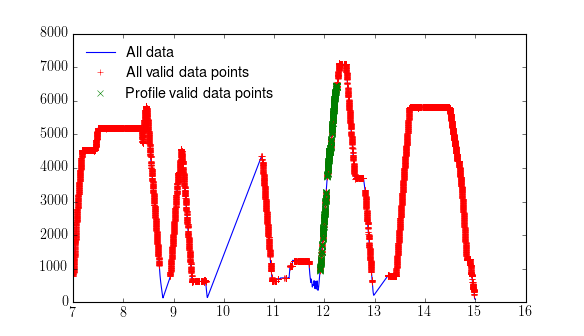

In [16]:
plt.figure()
plt.plot(s['utc'],s['Alt'],label='All data')
plt.plot(s['utc'][ifl],s['Alt'][ifl],'+r',label='All valid data points')
plt.plot(s['utc'][iflt],s['Alt'][iflt],'xg',label='Profile valid data points')
plt.legend(loc=2,numpoints=1,frameon=False)

<IPython.core.display.Javascript object>


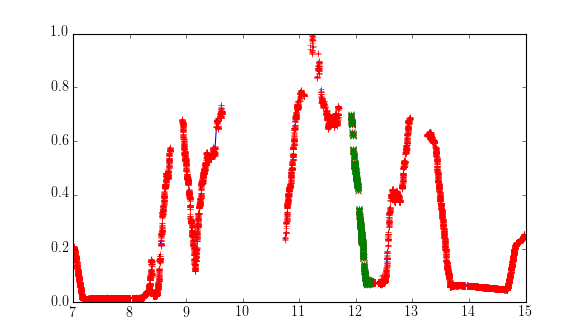

In [17]:
plt.figure()
plt.plot(s['utc'],s['tau_aero'][:,400])
plt.plot(s['utc'][ifl],s['tau_aero'][ifl,400],'+r')
plt.plot(s['utc'][iflt],s['tau_aero'][iflt,400],'xg')

<IPython.core.display.Javascript object>


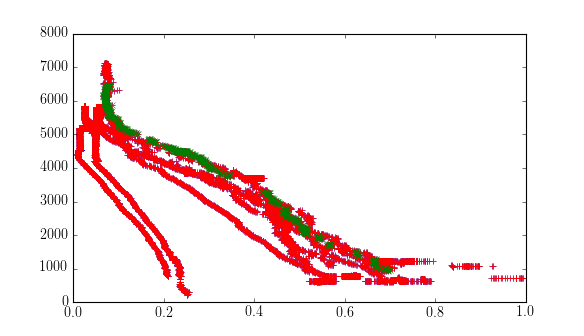

In [18]:
plt.figure()
plt.plot(s['tau_aero'][:,400],s['Alt'],'+')
plt.plot(s['tau_aero'][ifl,400],s['Alt'][ifl],'+r')
plt.plot(s['tau_aero'][iflt,400],s['Alt'][iflt],'xg')


In [15]:
# profile = [13.24,13.56] for 20160904
profile = [11.8667, 12.25]

In [16]:
it = (s['utc']>=profile[0]) & (s['utc']<=profile[1]) & (ifl) & (s['tau_aero'][:,400]<0.8)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [17]:
it = it.flatten()

## Load the 4STAR dirty clean correction file

In [18]:
s_dirty = fmat+'20160920_AOD_merge_marks.mat'

In [19]:
dm = sio.loadmat(s_dirty)

In [20]:
dm.keys()

['dCo',
 'dAODs',
 'AODs',
 '__header__',
 'wl_nm',
 '__globals__',
 'm_aero',
 'time',
 '__version__']

In [21]:
dm['utc'] = lm.toutc(lm.mat2py_time(dm['time']))

### Create a full wavelength tau correction from polyfit

In [22]:
import Sun_utils as su
from scipy import polyval
from write_utils import nearest_neighbor

In [23]:
dm['dAODs'].shape

(36090, 24)

Get the nearest neighboring daod values, matched to the utc time in the starsun.mat file

In [24]:
[(i,iv) for i,iv in enumerate(dm['wl_nm'].flatten())]

[(0, 355),
 (1, 380),
 (2, 452),
 (3, 470),
 (4, 501),
 (5, 520),
 (6, 530),
 (7, 532),
 (8, 550),
 (9, 606),
 (10, 620),
 (11, 660),
 (12, 675),
 (13, 700),
 (14, 781),
 (15, 865),
 (16, 1020),
 (17, 1040),
 (18, 1064),
 (19, 1236),
 (20, 1250),
 (21, 1559),
 (22, 1627),
 (23, 1650)]

In [25]:
daod = []
for i,iv in enumerate(dm['wl_nm'].flatten()):
    da = nearest_neighbor(dm['utc'],dm['dAODs'][:,i],s['utc'],dist=1.0/3600)
    daod.append(da)
    #break
daod = np.array(daod)
daod.shape

(24, 18178)

In [26]:
dm['dAODs'].shape

(36090, 24)

In [27]:
dm['polyaod'] = [su.aod_polyfit(dm['wl_nm'].flatten(),daod[:,i],polynum=2) for i in xrange(len(s['utc']))]    
np.shape(dm['polyaod'])

(18178, 3)

In [28]:
dm['tau'] = [polyval(dm['polyaod'][i].flatten(),s['w'].flatten()*1000.0) for i in xrange(len(s['utc']))] 

In [29]:
np.shape(dm['tau']),s['tau_aero'].shape

((18178, 1556), (18178, 1556))

In [30]:
s_list = s.keys()
s_list.sort()

In [31]:
aod = s['tau_aero']-np.array(dm['tau'])
aod.shape

(18178, 1556)

In [32]:
aod[it,i501][0],s['Alt'][it][0]

NameError: name 'i501' is not defined

### Plot to ensure proper correction

<IPython.core.display.Javascript object>


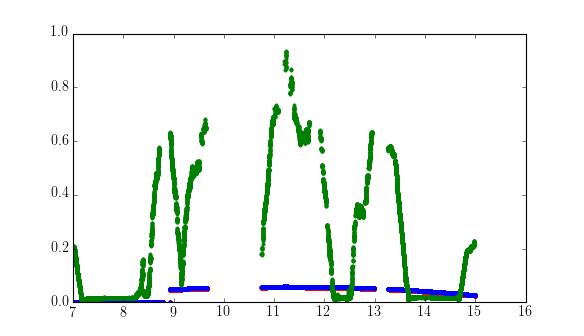

In [33]:
plt.figure()
#plt.plot(dm['utc'],dm['dAODs'][:,4],'k.')
plt.plot(s['utc'],daod[4,:],'r.')
plt.plot(s['utc'],np.array(dm['tau'])[:,400],'b.')
plt.plot(s['utc'],aod[:,400],'g.')

## Load the merge file with PDI and scat total

In [34]:
fpo = getpath('ORACLES_data_other_2016')
fpo

Return path named:  ORACLES_data_other_2016 /mnt/c/Users/sleblanc/Research/ORACLES/data_other/


u'/mnt/c/Users/sleblanc/Research/ORACLES/data_other/'

In [35]:
mrg,mrgh = lm.load_netcdf(fpo+'merge/mrg1_P3_{}_R24.nc'.format('20160912'),everything=True)

Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/merge/mrg1_P3_20160912_R24.nc
Outputting the Data subdatasets:
0: time
1: time_bounds
2: Start_UTC
3: Day_Of_Year
4: Latitude
5: Longitude
6: MSL_GPS_Altitude
7: Pressure_Altitude
8: Radar_Altitude
9: Ground_Speed
10: True_Air_Speed
11: Indicated_Air_Speed
12: Mach_Number
13: Vertical_Speed
14: True_Heading
15: Track_Angle
16: Drift_Angle
17: Pitch_Angle
18: Roll_Angle
19: Static_Air_Temp
20: Potential_Temp
21: Dew_Point
22: Total_Air_Temp
23: IR_Surf_Temp
24: Static_Pressure
25: Cabin_Pressure
26: Wind_Speed
27: Wind_Direction
28: Solar_Zenith_Angle
29: Aircraft_Sun_Elevation
30: Sun_Azimuth
31: Aircraft_Sun_Azimuth
32: Mixing_Ratio
33: Part_Press_Water_Vapor
34: Sat_Vapor_Press_H2O
35: Sat_Vapor_Press_Ice
36: Relative_Humidity
37: WINDS_Pitch_deg
38: WINDS_Roll_deg
39: WINDS_Tstat_degC
40: WINDS_u_ms-1
41: WINDS_v_ms-1
42: WINDS_w_ms-1
43: WINDS_WSPD_ms-1
44: CO_ppbv
45: CO2_ppmv
46: COMA_H2O_ppmv
47: O3_ppbv
48: PTI_tim

In [36]:
ll  = mrgh.keys()

In [37]:
for l in ll:
    if l.startswith('Scat'): 
        print l

Scat540RRwet
ScatTSI1
ScatTSI2
Scat540RRdry
Scattering_interpolated
ScatTSI1_ATP


In [38]:
for l in ll:
    if l.startswith('PDI'): 
        print l

PDIdiameters
PDI-CDNC_dNdlogd
PDIdiameter


In [39]:
diam1 = np.log(mrg['PDIdiameters'][:,1])
diam0 = np.log(mrg['PDIdiameters'][:,0])
diam = diam1-diam0

In [40]:
diam

array([0.04000003, 0.04000009, 0.03999987, 0.0399999 , 0.04000022,
       0.03999999, 0.03999997, 0.03999994, 0.04000008, 0.04000003,
       0.0399998 , 0.04000016, 0.03996378, 0.04003608, 0.04000006,
       0.0400001 , 0.03999997, 0.03999992, 0.04000008, 0.03999999,
       0.03999991, 0.04000012, 0.03999993, 0.03999996, 0.04000004,
       0.04000003, 0.03999995, 0.04000006, 0.03999996, 0.04000002,
       0.03999959, 0.04000019, 0.04000045, 0.03999942, 0.04000069,
       0.03999997, 0.03999974, 0.03999977, 0.04000045, 0.03999998,
       0.04000006, 0.03999948, 0.04000016, 0.04000012, 0.03999985,
       0.0400002 , 0.03999974, 0.04000013, 0.03999982, 0.04000015,
       0.03999997, 0.03999991, 0.03999999, 0.04000012, 0.04000015,
       0.04001931, 0.03998056, 0.00669526, 0.07330491, 0.03999987,
       0.03999986, 0.04000014, 0.03999991, 0.03999997, 0.04000014,
       0.03999995, 0.04000006, 0.04000003, 0.03999985, 0.04000001,
       0.04000004, 0.04000003, 0.03999996, 0.03998445, 0.04001

In [41]:
cdn = np.nansum(mrg['PDI-CDNC_dNdlogd']*diam,axis=1)

In [42]:
cdn.shape

(30176,)

In [43]:
mrgh['PDI-CDNC_dNdlogd']

<type 'netCDF4._netCDF4.Variable'>
float64 PDI-CDNC_dNdlogd(time, PDIdiameter)
    least_significant_digit: 3
    units: #/cm3
    long_name: Cloud Drop Number Concentration (dNdlogDp) by the FPDR-PDI
    history: 2018-06-27 06:37:45 Merged using merge
    source: C:\data\source\PDI\PDI-CDNC_P3_20160912_R1.ict
    missing_value: -9999.0
unlimited dimensions: 
current shape = (30176, 128)
filling on, default _FillValue of 9.96920996839e+36 used

In [44]:
mrg['PDI-CDNC_dNdlogd'].shape

(30176, 128)

In [45]:
mrg['AOD'].shape

(30176, 24)

In [46]:
mrg['AODwavelength']

array([ 355.,  380.,  452.,  470.,  501.,  520.,  530.,  532.,  550.,
        606.,  620.,  660.,  675.,  700.,  781.,  865., 1020., 1040.,
       1064., 1236., 1250., 1559., 1627., 1650.])

In [47]:
mrgh['qual_flag']

<type 'netCDF4._netCDF4.Variable'>
float64 qual_flag(time)
    least_significant_digit: 0
    units: unitless
    long_name: quality of retrieved AOD: 0=good; 1=poor
    history: 2018-06-27 06:37:45 Merged using merge
    source: C:\data\source\STAR\4STAR-AOD_P3_20160912_R3.ict
    missing_value: -9999.0
unlimited dimensions: 
current shape = (30176,)
filling on, default _FillValue of 9.96920996839e+36 used

In [38]:
aodm = np.ma.masked_array(mrg['AOD'][:,4],mrg['qual_flag']==0)

In [48]:
mrgh['CDP_Conc']

KeyError: 'CDP_Conc'

In [49]:
mrgh['PDI-CDNC_dNdlogd']

<type 'netCDF4._netCDF4.Variable'>
float64 PDI-CDNC_dNdlogd(time, PDIdiameter)
    least_significant_digit: 3
    units: #/cm3
    long_name: Cloud Drop Number Concentration (dNdlogDp) by the FPDR-PDI
    history: 2018-06-27 06:37:45 Merged using merge
    source: C:\data\source\PDI\PDI-CDNC_P3_20160912_R1.ict
    missing_value: -9999.0
unlimited dimensions: 
current shape = (30176, 128)
filling on, default _FillValue of 9.96920996839e+36 used

In [50]:
mrg['nephelometerwavelength']

array([450., 550., 700.])

### Plot the vertical distribution of the AOD, scat, and total number from PDI

In [51]:
imfl = (mrg['Start_UTC']/3600.0 > profile[0]-0.01)&(mrg['Start_UTC']/3600.0<profile[1]+0.07)

In [52]:
imfl = (mrg['Start_UTC']/3600.0 > 14.12)&(mrg['Start_UTC']/3600.0<14.55)
imfl1 = (mrg['Start_UTC']/3600.0 > 14.21)&(mrg['Start_UTC']/3600.0<14.55)
imfl2 = (mrg['Start_UTC']/3600.0 > 10.91)&(mrg['Start_UTC']/3600.0<11.37)

<IPython.core.display.Javascript object>


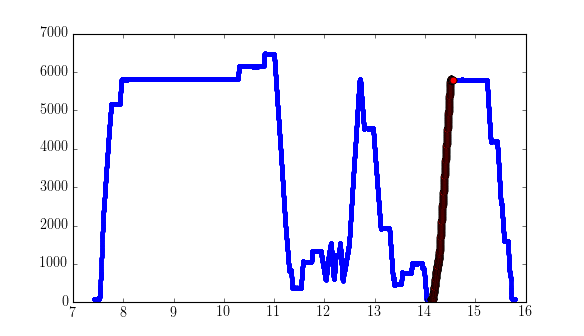

In [53]:
plt.figure()
plt.plot(mrg['Start_UTC']/3600.0,mrg['MSL_GPS_Altitude'],'.b')
plt.plot(mrg['Start_UTC'][imfl]/3600.0,mrg['MSL_GPS_Altitude'][imfl],'or')


<IPython.core.display.Javascript object>


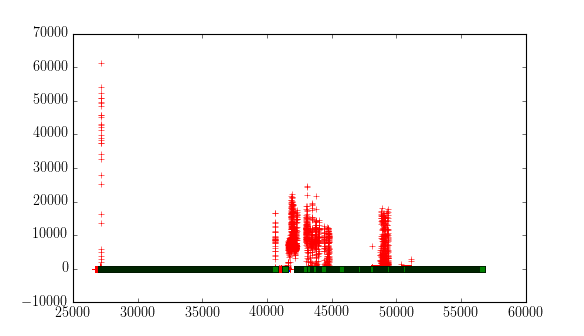

In [56]:
plt.figure()
plt.plot(mrg['Start_UTC'],mrg['ScatTSI1_ATP'],'.b')
plt.plot(mrg['Start_UTC'],cdn,'+r')
plt.plot(mrg['Start_UTC'],mrg['AOD'][:,4],'sg')

In [54]:
imflqa = (mrg['qual_flag']==0)&(imfl1==True)
imfl2qa = (mrg['qual_flag']==0)&(imfl2==True)

<IPython.core.display.Javascript object>


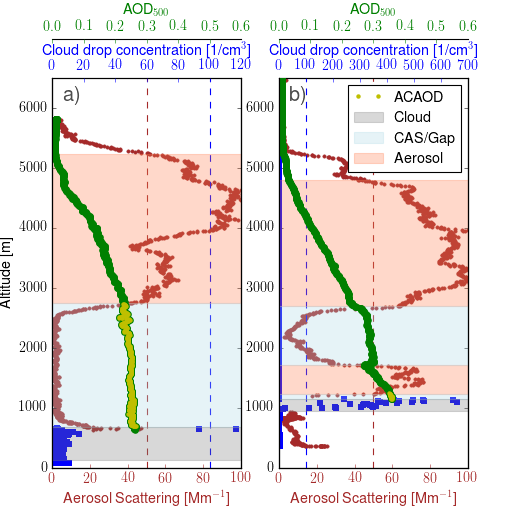

In [54]:
fig = plt.figure(figsize=(6.5,6.5))
ax1 = fig.add_subplot(121)
fig.subplots_adjust(top=0.85,left=0.1)
ax1.plot(mrg['ScatTSI1_ATP'][imfl1,1]*1.1,mrg['MSL_GPS_Altitude'][imfl1],'.',color='brown')
ax1.set_xlabel('Aerosol Scattering [Mm$^{{-1}}$]')
ax1.set_xlim([0,100])
ax1.set_ylabel('Altitude [m]')
ax1.axvline(50,ls='--',color='brown')
ax2 = ax1.twiny()
ax2.plot(cdn[imfl],mrg['MSL_GPS_Altitude'][imfl],'sb',markeredgecolor='None')
ax2.set_xlabel('Cloud drop concentration [1/cm$^{{3}}$]')
ax2.axvline(100,ls='--',color='b')
ax3 = ax1.twiny()
ax3.plot(mrg['AOD'][imflqa,4],mrg['MSL_GPS_Altitude'][imflqa],'og',markeredgecolor='None',markersize=6)
ax3.set_xlabel('AOD$_{{500}}$')
ax3.set_xlim([0,0.6])
ax3.spines["top"].set_position(("axes", 1.1))
ax3.set_ylim([0,6500])

ax1.xaxis.label.set_color('brown')
ax1.tick_params(axis='x', colors=('brown'))
ax2.xaxis.label.set_color('b')
ax2.tick_params(axis='x', colors=('b'))
ax3.xaxis.label.set_color('green')
ax3.tick_params(axis='x', colors=('green'))
plt.legend(frameon=False)

ax3.axhspan(137,690,color='grey',alpha=0.3,zorder=-10,label='Cloud')
ax3.axhspan(690,2745,color='lightblue',alpha=0.3,zorder=-11,label='CAS/Gap')
ax3.axhspan(2750,5240,color='coral',alpha=0.3,zorder=-12,label='Aerosol')
iffl = (mrg['MSL_GPS_Altitude'][imflqa]>690.0) & (mrg['MSL_GPS_Altitude'][imflqa]<2735.0)
ax3.plot(mrg['AOD'][imflqa,4][iffl],mrg['MSL_GPS_Altitude'][imflqa][iffl],'oy',
         label='ACAOD',markeredgecolor='None',markersize=4)

#ax3.legend(frameon=True,loc=7,bbox_to_anchor=(1.02,0.3))

ax4 = fig.add_subplot(122)
ax4.plot(mrg['ScatTSI1_ATP'][imfl2,1],mrg['MSL_GPS_Altitude'][imfl2],'.',color='brown')
ax4.set_xlabel('Aerosol Scattering [Mm$^{{-1}}$]')
ax4.axvline(50,ls='--',color='brown')
ax4.set_xlim([0,100])
#ax4.set_ylabel('Altitude [m]')
ax5 = ax4.twiny()
ax5.plot(cdn[imfl2],mrg['MSL_GPS_Altitude'][imfl2],'sb',markeredgecolor='None')
ax5.set_xlabel('Cloud drop concentration [1/cm$^{{3}}$]')
#ax5.set_xlim(0,10000)
ax5.axvline(100,ls='--',color='b')
ax6 = ax4.twiny()
ax6.plot(mrg['AOD'][imfl2qa,4],mrg['MSL_GPS_Altitude'][imfl2qa],'og',markeredgecolor='None',markersize=6)
ax6.set_xlabel('AOD$_{{500}}$')
ax6.set_xlim([0,0.6])
ax6.spines["top"].set_position(("axes", 1.1))
ax6.set_ylim([0,6500])

ax4.xaxis.label.set_color('brown')
ax4.tick_params(axis='x', colors=('brown'))
ax5.xaxis.label.set_color('b')
ax5.tick_params(axis='x', colors=('b'))
ax6.xaxis.label.set_color('green')
ax6.tick_params(axis='x', colors=('green'))
#plt.legend(frameon=False)

ax6.axhspan(948,1148,color='grey',alpha=0.3,zorder=-10,label='Cloud')
ax6.axhspan(1148,1240,color='lightblue',alpha=0.3,zorder=-11,label='CAS/Gap')
ax6.axhspan(1715,2692,color='lightblue',alpha=0.3,zorder=-11)
ax6.axhspan(1240,1715,color='coral',alpha=0.3,zorder=-12,label='Aerosol')
ax6.axhspan(2692,4805,color='coral',alpha=0.3,zorder=-12)

iff2l = (mrg['MSL_GPS_Altitude'][imfl2qa]>1147.0) & (mrg['MSL_GPS_Altitude'][imfl2qa]<1250.0)
ax6.plot(mrg['AOD'][imfl2qa,4][iff2l],mrg['MSL_GPS_Altitude'][imfl2qa][iff2l],'oy',
         label='ACAOD',markeredgecolor='None',markersize=4)

ax6.legend(frameon=True,loc=1)

#ax3.text(0.03,6200,'a)')
#ax6.text(0.03,6200,'b)')
pu.sub_note('a)',ax=ax3,dx=0.05)
pu.sub_note('b)',ax=ax6,dx=0.05)

plt.savefig(fp+'plot_v3/Profile_example_gap_20160912.png',dpi=600,transparent=True)
plt.savefig(fp+'plot_v3/Profile_example_gap_20160912.svg')
plt.savefig(fp+'plot_v3/Profile_example_gap_20160912.eps')
plt.savefig(fp+'plot_v3/Profile_example_gap_20160912.pdf')


In [63]:
np.nanmean(mrg['Latitude'][imfl]), np.nanmean(mrg['Longitude'][imfl])

(-18.649907621515901, 8.6572487547309773)

In [64]:
np.nanmean(mrg['Latitude'][imfl2]), np.nanmean(mrg['Longitude'][imfl2])

(-10.240030963939482, 0.22214496539078452)

# Plot the geographical region and add context

<IPython.core.display.Javascript object>


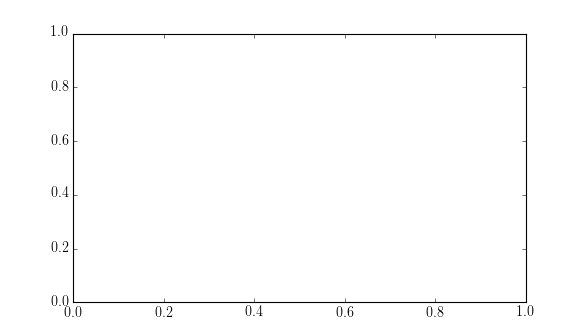

In [70]:
#set up a easy plotting function
def make_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=14.0,lat_0=-22.0,
            llcrnrlon=-10.0, llcrnrlat=-25.0,
            urcrnrlon=20.0, urcrnrlat=0,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-10,20,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(-25,1,14),labels=[1,0,0,0])
    return m


In [110]:
np.nanmean(s['Lon'][it]),np.nanmean(s['Lat'][it])

(8.900275675675676, -16.668926891891893)

In [71]:
s['tau_aero'][it,i501]

NameError: name 'i501' is not defined

In [ ]:
fig,ax = plt.subplots(1,1)
m = make_map(ax)
m.plot(s['Lon'],s['Lat'],'b.',latlon=True)
m.plot(s['Lon'][it],s['Lat'][it],'r+',latlon=True)
plt.savefig(fp+'plot/map_take_off_profile_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Now plot the vertical distribution of AOD and Extinction

## Vertical profile of AOD

In [85]:
i515 = np.argmin(abs(s['w']*1000.0-515.0))
i380 = np.argmin(abs(s['w']*1000.0-380.0))
i865 = np.argmin(abs(s['w']*1000.0-865.0))
i1250 = np.argmin(abs(s['w']*1000.0-1250.0))

In [86]:
ii = np.where(it)[0][-3]

In [87]:
tau_max = 1.0

In [45]:
ii

11006

In [46]:
s['tau_aero'].shape

(18178, 1556)

<IPython.core.display.Javascript object>


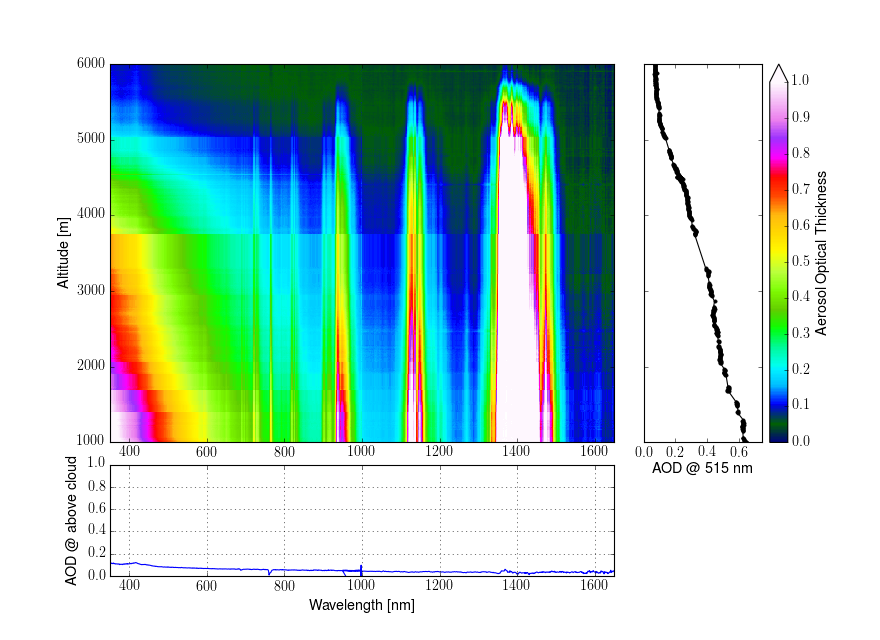

In [102]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_xscale('log')
ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'k.-')
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([1000,6000])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.2,0.4,0.6])
ax2.set_xlim([0.0,tau_max*0.75])
ax2.set_xlabel('AOD @ 515 nm')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][ii,:].flatten())
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax3.grid()
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD @ above cloud')
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_{}.png'.format(dd),dpi=600,transparent=True)

In [82]:
u = np.where(it)[0]
iit = u[np.linspace(0,len(u)-1,6).astype(int)]

In [83]:
tau_max = 1.2

In [81]:
i532 = np.argmin(abs(s['w']*1000.0-532.0))
i355 = np.argmin(abs(s['w']*1000.0-355.0))
i1064 = np.argmin(abs(s['w']*1000.0-1064.0))

In [49]:
w_archive = [354.9,380.0,451.7,470.2,500.7,520,530.3,532.0,550.3,605.5,619.7,660.1,675.2,699.7,780.6,864.6,1019.9,1039.6,1064.2,1235.8,1249.9,1558.7,1626.6,1650.1]
iw_archive = [np.argmin(abs(s['w']*1000.0-i)) for i in w_archive]

In [ ]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_loglog_{}.png'.format(dd),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


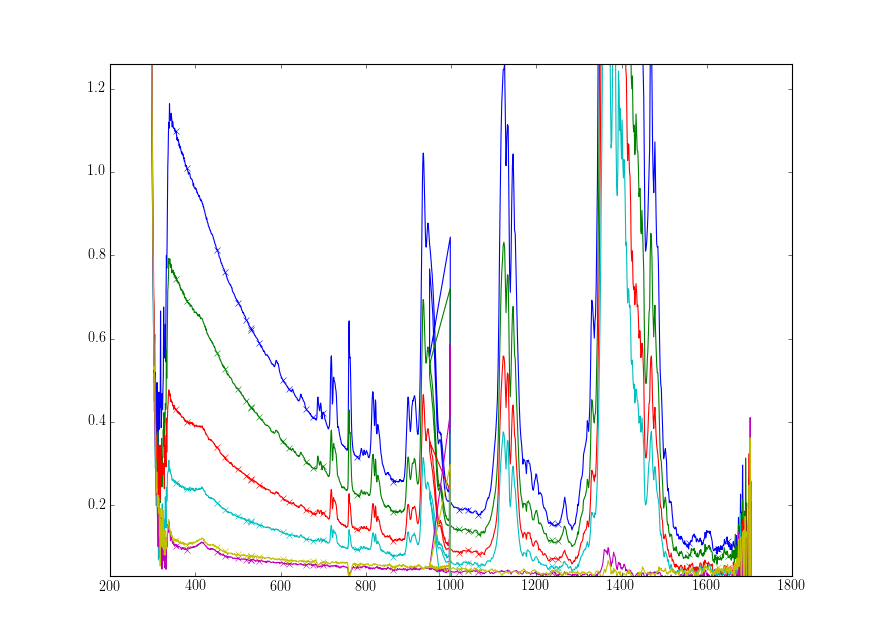

In [58]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

i532 = np.argmin(abs(s['w']*1000.0-532.0))
i355 = np.argmin(abs(s['w']*1000.0-355.0))
i1064 = np.argmin(abs(s['w']*1000.0-1064.0))

ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
ax2.plot(s['tau_aero'][it,i532],s['Alt'][it],'g.-',label='535 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_loglog_hsrlwvl_{}.png'.format(dd),dpi=500,transparent=True)

### Redo the color plot, but with shading for the gas aod

In [50]:
s['tau_aero'][:,1041] = np.nan
s['tau_aero'][:,1042] = np.nan
s['tau_aero'][:,1043] = np.nan
s['tau_aero'][:,1044] = np.nan
s['tau_aero'][:,1045] = np.nan

<IPython.core.display.Javascript object>


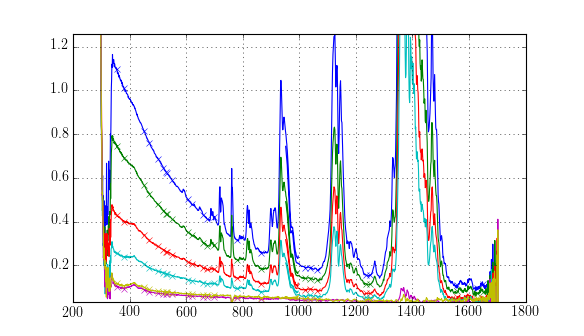

In [77]:
plt.figure()
ax3 = plt.subplot(1,1,1)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax3.set_ylim([0.03,tau_max*1.05])
plt.grid()

In [51]:
shade_rg = [[584.0,597.0],
            [625.5,631.6],
            [643.0,658.0],
            [684.0,705.0],
            [713.0,741.0],
            [756.0,770.0],
            [785.5,805.0],
            [810.0,842.0],
            [890.0,998.0],
            [1077.0,1228.0],
            [1257.0,1277.0],
            [1293.0,1521.0]]

In [154]:
i501 = np.argmin(abs(s['w']*1000.0-501.0))
i532 = np.argmin(abs(s['w']*1000.0-532.0))
i355 = np.argmin(abs(s['w']*1000.0-355.0))
i1064 = np.argmin(abs(s['w']*1000.0-1064.0))

<IPython.core.display.Javascript object>


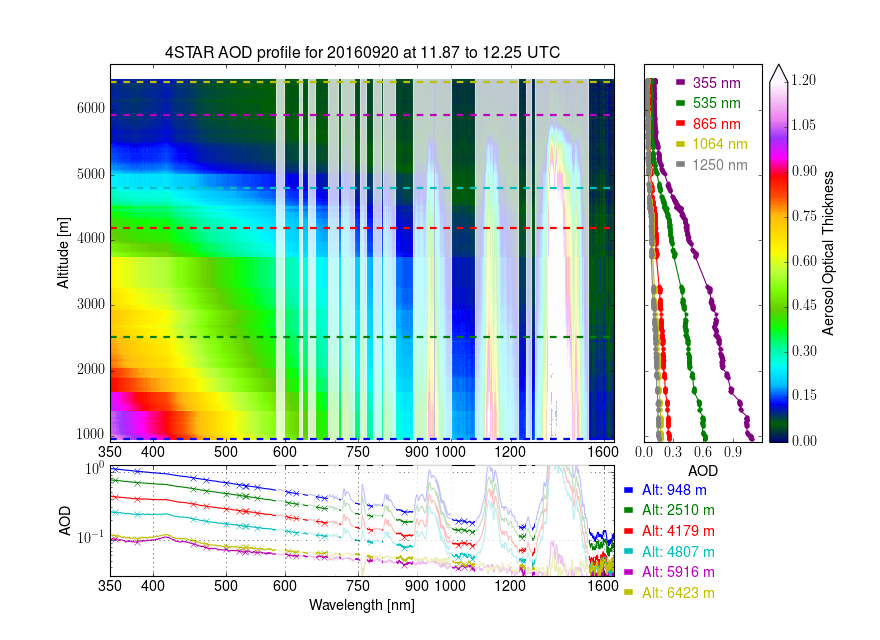

[None, None, None, None, None, None, None, None, None]

In [74]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
for rg in shade_rg:
    plt.axvspan(rg[0],rg[1],color='white',alpha=0.75)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
ax2.plot(s['tau_aero'][it,i532],s['Alt'][it],'g.-',label='535 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
for rg in shade_rg:
    ax3.axvspan(rg[0],rg[1],color='white',alpha=0.75,zorder=200)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot_v2/AOD_Alt_profile_loglog_hsrlwvl_shaded_{}.png'.format(dd),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


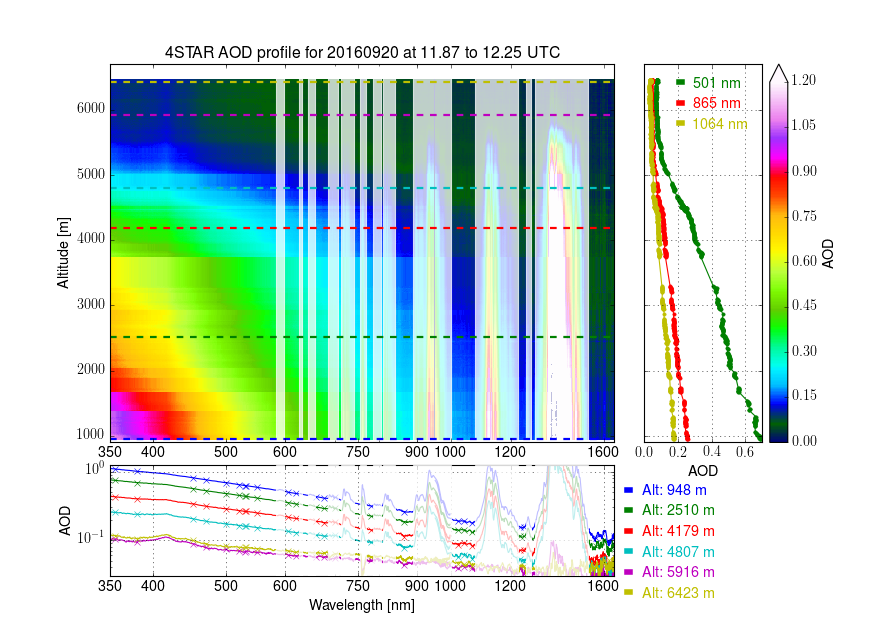

/usr/lib/python2.7/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/usr/lib/python2.7/dist-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


In [44]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
for rg in shade_rg:
    plt.axvspan(rg[0],rg[1],color='white',alpha=0.75)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

#ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
ax2.plot(s['tau_aero'][it,i501],s['Alt'][it],'g.-',label='501 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')

#ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.2,0.4,0.6])
ax2.set_xlim([0.0,0.7])
plt.grid()
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('AOD')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
for rg in shade_rg:
    ax3.axvspan(rg[0],rg[1],color='white',alpha=0.75,zorder=200)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot_v2/AOD_Alt_profile_loglog_hsrlwvl_shaded_v2_{}.png'.format(dd),dpi=500,transparent=True)

<IPython.core.display.Javascript object>


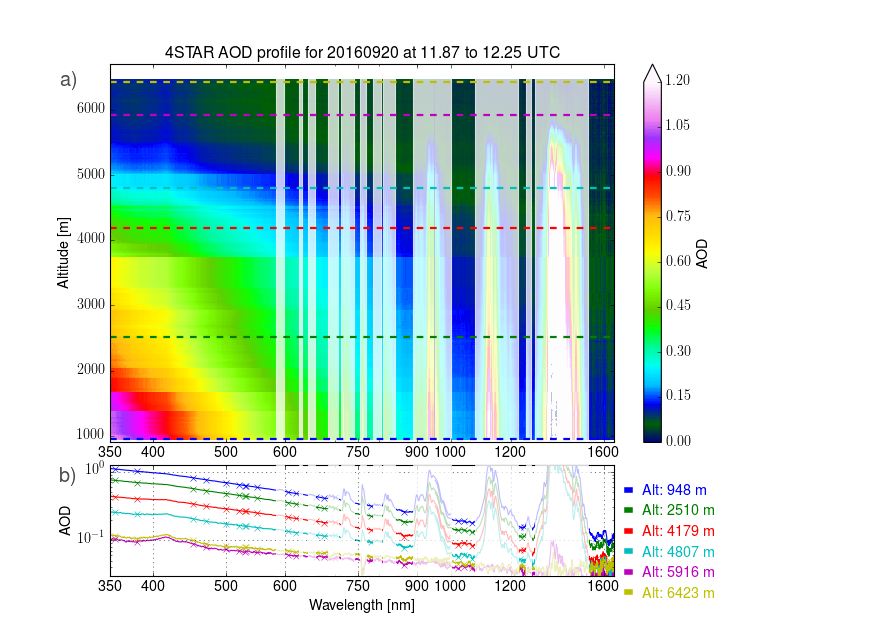

In [115]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
for rg in shade_rg:
    plt.axvspan(rg[0],rg[1],color='white',alpha=0.75)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

#axc = plt.colorbar(cb,extend='max')
#axc.set_label('AOD')

ax2 = plt.subplot2grid((4,4),(0,3),rowspan=3)
pax2 = ax2.get_position()
ax2.set_position([pax2.xmin,pax2.ymin,0.02,pax2.height])
#ax2.set_axis_off()

axc = plt.colorbar(cb,extend='max',cax=ax2)
axc.set_label('AOD')

#ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
#ax2.plot(s['tau_aero'][it,i501],s['Alt'][it],'g.-',label='501 nm')
#ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
#ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')

#ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

#plt.setp(ax2.get_yticklabels(), visible=False)
#ax2.set_xticks([0.0,0.2,0.4,0.6])
#ax2.set_xlim([0.0,0.7])
#plt.grid()
#ax2.set_xlabel('AOD')
#ax2.set_ylim([900,6700])
#leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
#for line,text in zip(leg.get_lines(), leg.get_texts()):
#    text.set_color(line.get_color())
#    line.set_linewidth(5.0)


ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
for rg in shade_rg:
    ax3.axvspan(rg[0],rg[1],color='white',alpha=0.75,zorder=200)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)

pu.sub_note('a)',ax=ax,dx=-0.11)
pu.sub_note('b)',ax=ax3,dx=-0.11)

plt.savefig(fp+'plot_v3/AOD_Alt_profile_loglog_hsrlwvl_shaded_v3_{}.png'.format(dd),dpi=500,transparent=True)
plt.savefig(fp+'plot_v3/AOD_Alt_profile_loglog_hsrlwvl_shaded_v3_{}.eps'.format(dd))
plt.savefig(fp+'plot_v3/AOD_Alt_profile_loglog_hsrlwvl_shaded_v3_{}.pdf'.format(dd))

### Add the angstrom exponent vertical dependence

In [52]:
import Sun_utils as su

In [53]:
s['polyaod'] = []
s['polylogaod'] = []

In [54]:
for i in np.where(it)[0]:
    pp = su.aod_polyfit(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive],polynum=4)
    s['polyaod'].append(pp)
    pl = su.logaod_polyfit(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive],polynum=4)
    s['polylogaod'].append(pl)
s['polyaod'] = np.array(s['polyaod'])
s['polylogaod'] = np.array(s['polylogaod'])

In [55]:
s['angs'] = su.angstrom_from_logpoly(s['polylogaod'],[380.0,515.0,865.0,1250.0],polynum=4)

In [56]:
s['angs'].shape

(740, 4)

In [89]:
i470 = np.argmin(abs(s['w']*1000.0-470.0))
i865 = np.argmin(abs(s['w']*1000.0-865.0))
s['angs_470_865'] = []
for i in np.where(it)[0]:
    to = np.log(s['tau_aero'][i,i865])-np.log(s['tau_aero'][i,i470])
    bo = np.log(s['w'][0,i865]*1000.0)-np.log(s['w'][0,i470]*1000.0)
    s['angs_470_865'].append(to/bo*-1.0)
s['angs_470_865'] = np.array(s['angs_470_865'])

<IPython.core.display.Javascript object>


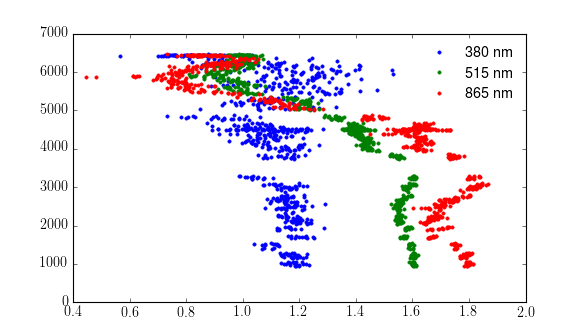

In [122]:
plt.figure()
plt.plot(s['angs'][:,0],s['Alt'][it],'.',label='380 nm')
plt.plot(s['angs'][:,1],s['Alt'][it],'.',label='515 nm')
plt.plot(s['angs'][:,2],s['Alt'][it],'.',label='865 nm')
plt.legend(numpoints=1,frameon=False)

<IPython.core.display.Javascript object>


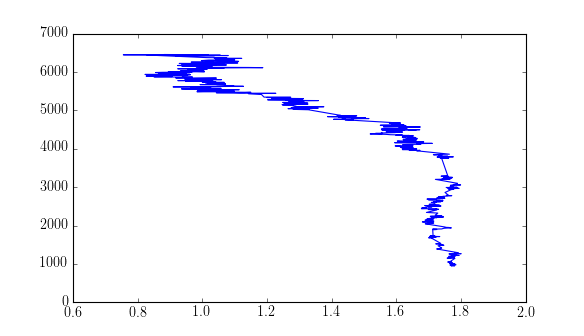

In [78]:
plt.figure()
plt.plot(s['angs_470_865'],s['Alt'][it])

In [58]:
def smoothb(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [453]:
fig = plt.figure(figsize=(11,7))
plt.title('{} profile at {}h'.format(dd,profile[0]))
fig.subplots_adjust(wspace=0.1)
ax = plt.subplot2grid((4,5),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,5),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
ax2.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((4,5),(0,4),sharey=ax,rowspan=3)
plt.plot(smoothb(s['angs'][:,0],10),s['Alt'][it],'.-',color='purple',label='380 nm')
plt.plot(smoothb(s['angs'][:,1],10),s['Alt'][it],'g.-',label='515 nm')
plt.plot(smoothb(s['angs'][:,2],10),s['Alt'][it],'r.-',label='865 nm')
#plt.plot(smoothb(s['angs'][:,3],10),s['Alt'][it],'.-',color='grey',label='1250 nm')
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([0.8,1.2,1.6,2.0])
axa.set_xlim([0.6,2.0])
axa.set_xlabel('Angstrom')
axa.set_ylim([900,6700])
axa.grid()

axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,5),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax.set_xscale('log')
ax3.set_xscale('log')
ax.set_xticks([350,400,500,600,700,850,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,700,850,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
plt.setp(ax.get_xticklabels(), visible=True)

ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))

plt.savefig(fp+'plot/AOD_Alt_profile_log_angstrom_{}.png'.format(dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>

AttributeError: Unknown property xr

In [ ]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
for rg in shade_rg:
    plt.axvspan(rg[0],rg[1],color='white',alpha=0.75)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

#ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
ax2.plot(s['tau_aero'][it,i501],s['Alt'][it],'g.-',label='501 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')

#ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.2,0.4,0.6])
ax2.set_xlim([0.0,0.7])
plt.grid()
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('AOD')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
for rg in shade_rg:
    ax3.axvspan(rg[0],rg[1],color='white',alpha=0.75,zorder=200)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot_v2/AOD_Alt_profile_loglog_hsrlwvl_shaded_v2_{}.png'.format(dd),dpi=500,transparent=True)

## Redo but with the dirty corrected data

<IPython.core.display.Javascript object>


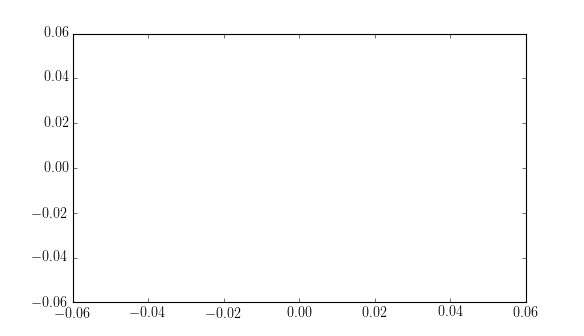

In [441]:
plt.figure()
plt.plot(s['utc'],aod[:,400])

In [59]:
polylogaod = np.array([su.logaod_polyfit(s['w'].flatten()[iw_archive]*1000.0,aod[i,iw_archive],polynum=4) for i in np.where(it)[0]])

Sun_utils.py:418: RuntimeWarning: invalid value encountered in log
  cc = polyfit(np.log(wvl),np.log(aod),polynum)


In [60]:
angs = su.angstrom_from_logpoly(polylogaod,[380.0,515.0,865.0,1250.0],polynum=4)

<IPython.core.display.Javascript object>


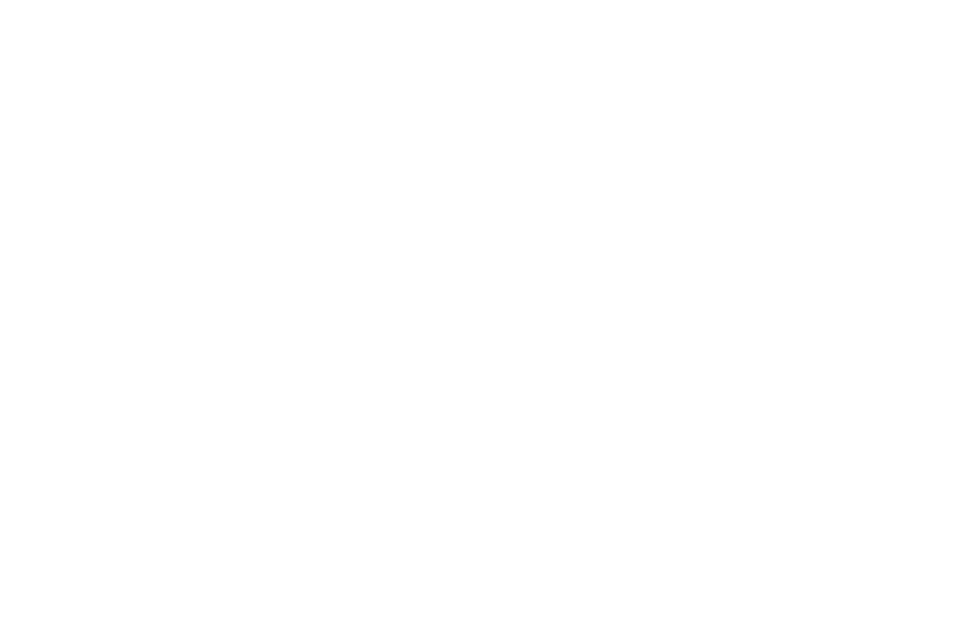

NameError: name 'smoothb' is not defined

In [125]:
fig = plt.figure(figsize=(12,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
fig.subplots_adjust(wspace=0.1)
ax = plt.subplot2grid((4,5),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),aod[it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,5),(0,3),sharey=ax,rowspan=3)

ax2.plot(aod[it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(aod[it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(aod[it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(aod[it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
ax2.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((4,5),(0,4),sharey=ax,rowspan=3)
plt.plot(smoothb(angs[:,0],10),s['Alt'][it],'.-',color='purple',label='380 nm')
plt.plot(smoothb(angs[:,1],10),s['Alt'][it],'g.-',label='515 nm')
plt.plot(smoothb(angs[:,2],10),s['Alt'][it],'r.-',label='865 nm')
#plt.plot(smoothb(s['angs'][:,3],10),s['Alt'][it],'.-',color='grey',label='1250 nm')
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([0.8,1.2,1.6,2.0])
axa.set_xlim([0.6,2.0])
axa.set_xlabel('Angstrom')
axa.set_ylim([900,6700])
axa.grid()

axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,5),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,aod[i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,aod[i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax.set_xscale('log')
ax3.set_xscale('log')
ax.set_xticks([350,400,500,600,700,850,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,700,850,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
plt.setp(ax.get_xticklabels(), visible=True)

ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))

#plt.savefig(fp+'plot/AOD_Alt_profile_log_angstrom_dirty_corrected{}.png'.format(dd),dpi=600,transparent=True)

## Vertical profile of extinction

In [55]:
from Sp_parameters import deriv,smooth
import scipy.stats as st
import scipy.interpolate as si

In [56]:
s['ext'] = np.zeros_like(s['tau_aero'])

In [98]:
nx = 1000
s['xext'] = np.zeros((nx,len(s['w'][0])))
xalt = np.linspace(np.min(s['Alt'][it][:,0]),np.max(s['Alt'][it][:,0]),nx)
xd = nearest_neighbor(s['Alt'][it][:,0],aod[it,i550],xalt,dist=5.0)
isn = np.isnan(xd)

In [99]:
for l,w in enumerate(s['w'][0]):
    s['ext'][it,l] = smooth(deriv(smooth(aod[it,l],50,nan=False,old=True),
                                  s['Alt'][it][:,0])*-1000000.0,9,nan=False,old=True) 
    fxaod = si.interp1d(s['Alt'][it][:,0],aod[it,l])
    xaod = fxaod(xalt)
    s['xext'][:,l] = smooth(deriv(smooth(xaod,70,nan=False,old=True),
                                  xalt)*-1000000.0,15,nan=False,old=True) 
    s['xext'][isn,l] = np.nan

Sp_parameters.py:113: RuntimeWarning: divide by zero encountered in true_divide
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:113: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))


<IPython.core.display.Javascript object>


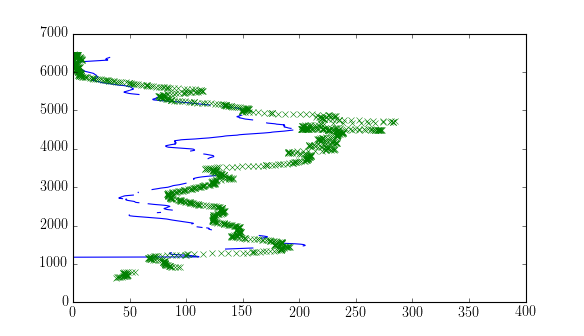

(0, 400)

In [220]:
plt.figure()
plt.plot(s['xext'][:,i540],xalt)
plt.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'x')
plt.xlim(0,400)

In [ ]:
def calc_ext(aod,alt,dz,su=0.0006):
    'Function that calculates the extinction coefficient profile'
    nbin = int((np.nanmax(alt)-np.nanmin(alt))/dz)
    aod_bin, dz_bin_edge, ibin = st.binned_statistic(alt,aod,bins=nbin)
    dz_bin = np.array([(dz_bin_edge[iz+1]+ddz)/2.0 for iz,ddz in enumerate(dz_bin_edge[0:-1])])
    if any(np.isfinite(aod_bin)):
        aodc = si.UnivariateSpline(dz_bin[np.isfinite(aod_bin)],aod_bin[np.isfinite(aod_bin)],s=su)
        extc_fx = aodc.derivative()
        extc = extc_fx(dz_bin)*-1000000.0
    else:
        extc = dz_bin*np.nan
    return extc,dz_bin

In [ ]:
s['ext_spline'] = []
for l,w in enumerate(s['w'][0]):
    ep,altz = calc_ext(s['tau_aero'][it,l], s['Alt'][it][:,0],50.0,su=0.0009)
    s['ext_spline'].append(ep)
s['ext_spline'] = np.array(s['ext_spline'])
s['ext_spline'].shape

<IPython.core.display.Javascript object>


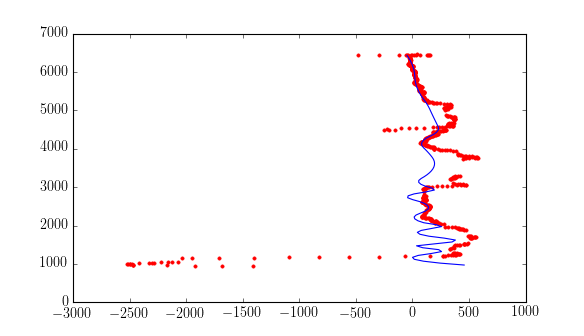

In [72]:
plt.figure()
#plt.plot(ext_500,dz_bin_edge[1:-1],'.')
#plt.plot(extt,dz_bin_edge[1:-1])
#plt.plot(extd,dz_bin,'mx')
plt.plot(s['ext'][it,400],s['Alt'][it],'r.')
plt.plot(s['ext_spline'][400,:],altz)
#plt.plot(mrg['scat'][mrg['it'],1]+mrg['abs'][mrg['it'],1],mrg['alt'][mrg['it']],'g+')
#plt.plot(extc,dz_bin,'ko')

<IPython.core.display.Javascript object>


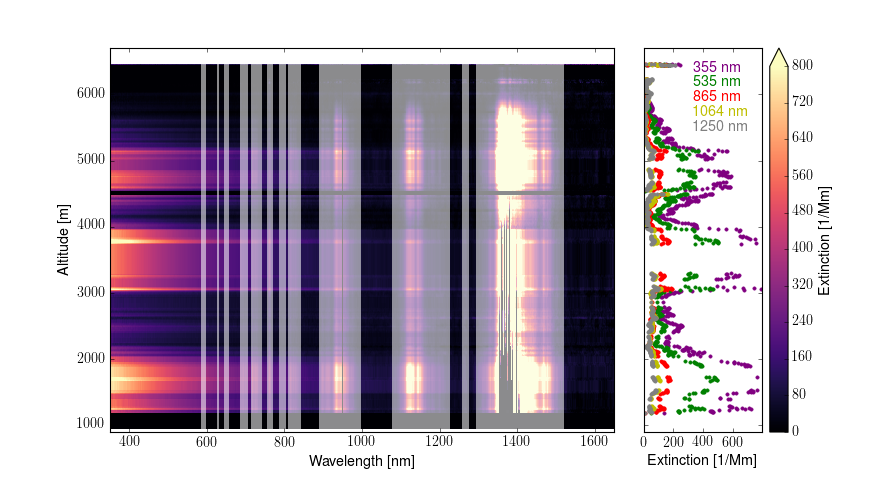

In [83]:
fig = plt.figure(figsize=(11,6))
ax = plt.subplot2grid((1,4),(0,0),colspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['ext'][it,:],
                   cmap='magma',vmin=0,vmax=800.0)

ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([900,6700])
ax.set_xlim([350,1650])

for rg in shade_rg:
    ax.axvspan(rg[0],rg[1],facecolor='white',alpha=0.55,edgecolor='None')

ax2 = plt.subplot2grid((1,4),(0,3),sharey=ax)

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')

axc = plt.colorbar(cb,extend='max')
axc.set_label('Extinction [1/Mm]')
    
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')

leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)

plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


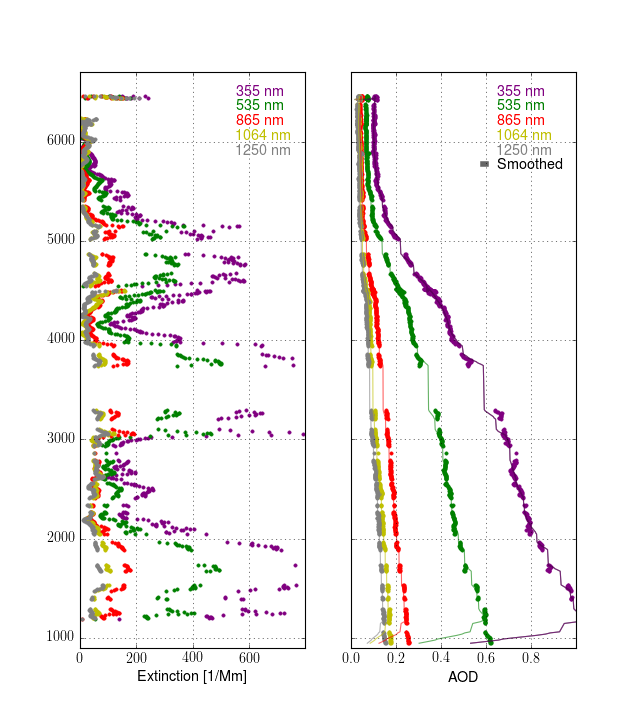

In [94]:
fig = plt.figure(figsize=(8,9))
ax2 = plt.subplot2grid((1,2),(0,0))

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')

#axc = plt.colorbar(cb,extend='max')
#axc.set_label('Extinction [1/Mm]')
    
#plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
    
ax3 = plt.subplot2grid((1,2),(0,1),sharey=ax2)
#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax3.plot(s['tau_aero'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(s['tau_aero'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')
ax3.plot(smooth(s['tau_aero'][it,i355],50,nan=False,old=True),s['Alt'][it],'-',color='k',label='Smoothed',alpha=0.6)

ax3.plot(smooth(s['tau_aero'][it,i355],50,nan=False,old=True),s['Alt'][it],'-',color='purple',alpha=0.6)
ax3.plot(smooth(s['tau_aero'][it,i532],50,nan=False,old=True),s['Alt'][it],'g-',alpha=0.6)
ax3.plot(smooth(s['tau_aero'][it,i865],50,nan=False,old=True),s['Alt'][it],'r-',alpha=0.6)
ax3.plot(smooth(s['tau_aero'][it,i1064],50,nan=False,old=True),s['Alt'][it],'-',color='y',alpha=0.6)
ax3.plot(smooth(s['tau_aero'][it,i1250],50,nan=False,old=True),s['Alt'][it],'-',color='grey',alpha=0.6)


#axc = plt.colorbar(cb,extend='max')
#axc.set_label('AOD')
    
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([900,6700])
ax3.set_xlabel('AOD')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_vs_AOD_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


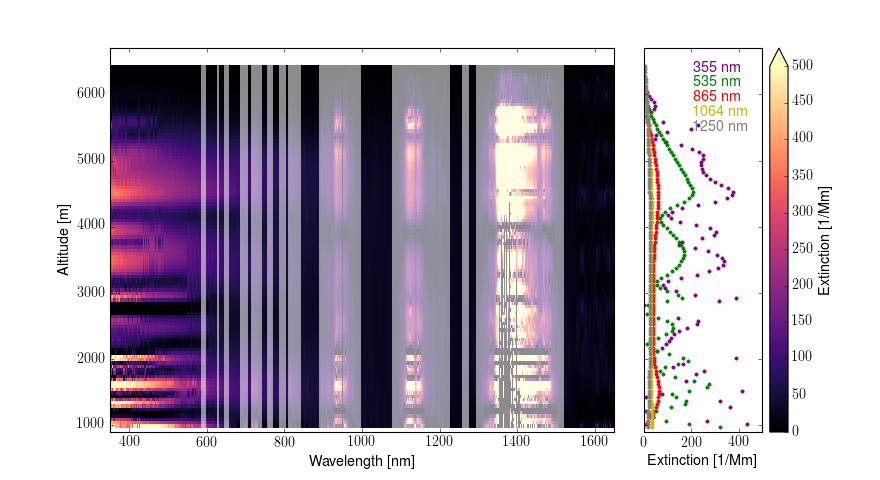

In [84]:
fig = plt.figure(figsize=(11,6))
ax = plt.subplot2grid((1,4),(0,0),colspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,altz,s['ext_spline'].T,
                   cmap='magma',vmin=0,vmax=500.0)

ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([900,6700])
ax.set_xlim([350,1650])

for rg in shade_rg:
    ax.axvspan(rg[0],rg[1],facecolor='white',alpha=0.55,edgecolor='None')

ax2 = plt.subplot2grid((1,4),(0,3),sharey=ax)

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext_spline'][i355,:],altz,'.',color='purple',label='355 nm')
ax2.plot(s['ext_spline'][i532,:],altz,'g.',label='535 nm')
ax2.plot(s['ext_spline'][i865,:],altz,'r.',label='865 nm')
ax2.plot(s['ext_spline'][i1064,:],altz,'.',color='y',label='1064 nm')
ax2.plot(s['ext_spline'][i1250,:],altz,'.',color='grey',label='1250 nm')

axc = plt.colorbar(cb,extend='max')
axc.set_label('Extinction [1/Mm]')
    
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0])
ax2.set_xlim([0.0,500.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')

leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)

plt.savefig(fp+'plot_v2/Ext_Alt_profile_spline_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

### Extinction profile, with spaces in missing data

In [64]:
alts = s['Alt'][it].flatten()
iholes = np.where((alts[1:]-alts[0:-1])>100.0)[0]
hole_flt = np.isnan(s['ext'][it,:])
for ih in iholes:
    hole_flt = hole_flt | (s['ext'][it,:]==s['ext'][it,:][ih,:])
sext = np.ma.masked_array(s['ext'][it,:],hole_flt)

<IPython.core.display.Javascript object>


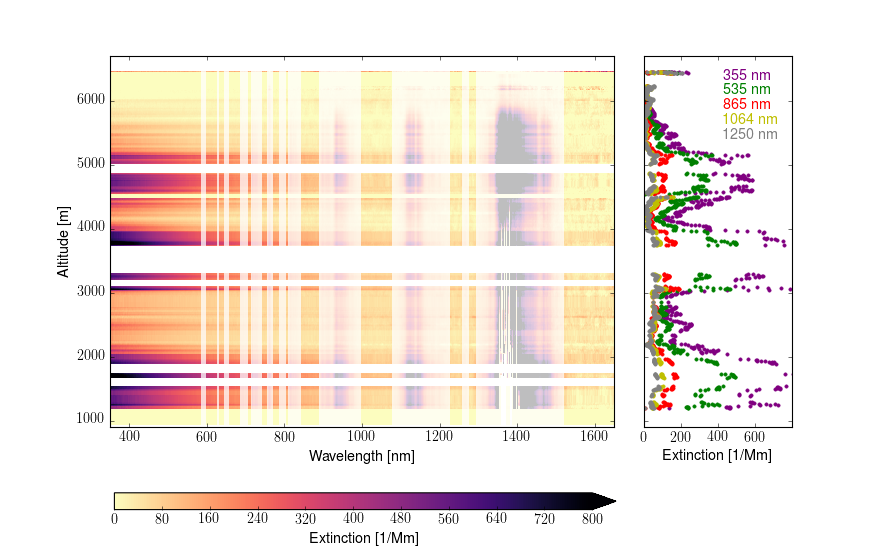

In [218]:
fig = plt.figure(figsize=(11,7))
ax = plt.subplot2grid((6,4),(0,0),colspan=3,rowspan=5)
cb = ax.pcolor(s['w'].flatten()*1000.0,alts,sext,
                   cmap='magma_r',vmin=0,vmax=800.0)

ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([900,6700])
ax.set_xlim([350,1650])

for rg in shade_rg:
    ax.axvspan(rg[0],rg[1],facecolor='white',alpha=0.75,edgecolor='None')

cbaxes=fig.add_axes([0.13, 0.09, 0.57, 0.03]) 
axc = plt.colorbar(cb,extend='max',orientation='horizontal',cax=cbaxes)
axc.set_label('Extinction [1/Mm]')

ax2 = plt.subplot2grid((6,4),(0,3),sharey=ax,rowspan=5)

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')
    
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')

leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)

plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_empty_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Add CO concentration

In [60]:
import load_utils as lu

In [61]:
coma,coma_h = lu.load_ict(fp+'/data_other/COMA_P3_20160920_R0.ict',return_header=True)

('Start_UTC', 'End_UTC', 'Mid_UTC', 'CO_ppbv', 'CO2_ppmv', 'H2O_ppmv')


In [62]:
itc = (coma['Start_UTC']>=profile[0]) & (coma['Start_UTC']<=profile[1]) & (coma['CO_ppbv']>0)

## Now add the CO to the figure

In [63]:
co_fx = si.interp1d(coma['Start_UTC'],coma['CO_ppbv'])
co = co_fx(s['utc'][it])

In [64]:
itc = (coma['Start_UTC']>profile[0]) & (coma['Start_UTC']<profile[1])

In [65]:
coutc = coma['Start_UTC'][itc]
coppb = coma['CO_ppbv'][itc]
coaltfx =  si.interp1d(s['utc'][it],s['Alt'][it][:,0],fill_value="extrapolate")
coalt = coaltfx(coma['Start_UTC'][itc])

In [66]:
coalt

array([ 178.05412254,  182.37770967,  186.70129681, ..., 6441.32359141,
       6443.91499909, 6446.50914899])

<IPython.core.display.Javascript object>


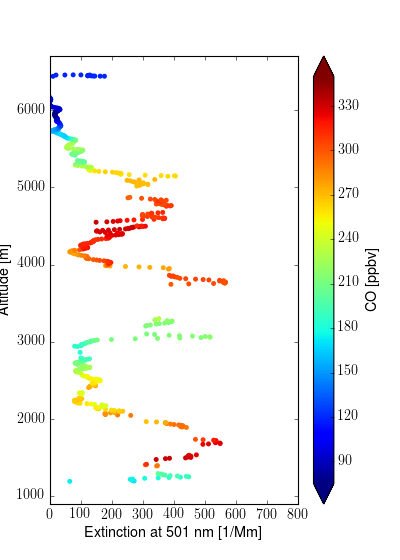

In [141]:
plt.figure(figsize=(5,7))
p = plt.scatter(s['ext'][it,i501],s['Alt'][it],c=co,vmin=75,vmax=350,cmap='jet',marker='o',edgecolor='None')
plt.xlabel('Extinction at 501 nm [1/Mm]')
plt.ylabel('Altitude [m]')
plt.xlim(0,800)
plt.ylim(900,6700)

cb = plt.colorbar(p,extend='both')
cb.set_label('CO [ppbv]')
plt.savefig(fp+'plot_v2/Ext_Alt_profile_CO_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

In [72]:
it_g = s['ext'][it,i501]>0.0
gg = np.where(it_g)[0]

NameError: name 'i501' is not defined

In [71]:
it_g.shape

(740,)

<IPython.core.display.Javascript object>


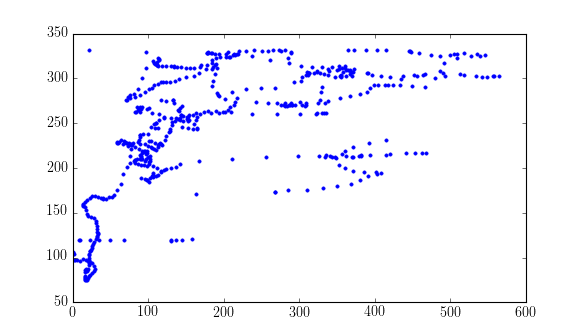

In [198]:
plt.figure()
plt.plot(s['ext'][it,i501][it_g],co[it_g],'.')
#pu.plot_lin(s['ext'][it,i501][it_g],co[it_g])
#plt.legend(frameon=False,loc=4)

In [ ]:
e_c = np.corrcoef(s['ext'][it,i501][it_g],co[it_g])

In [ ]:
e_c

<IPython.core.display.Javascript object>


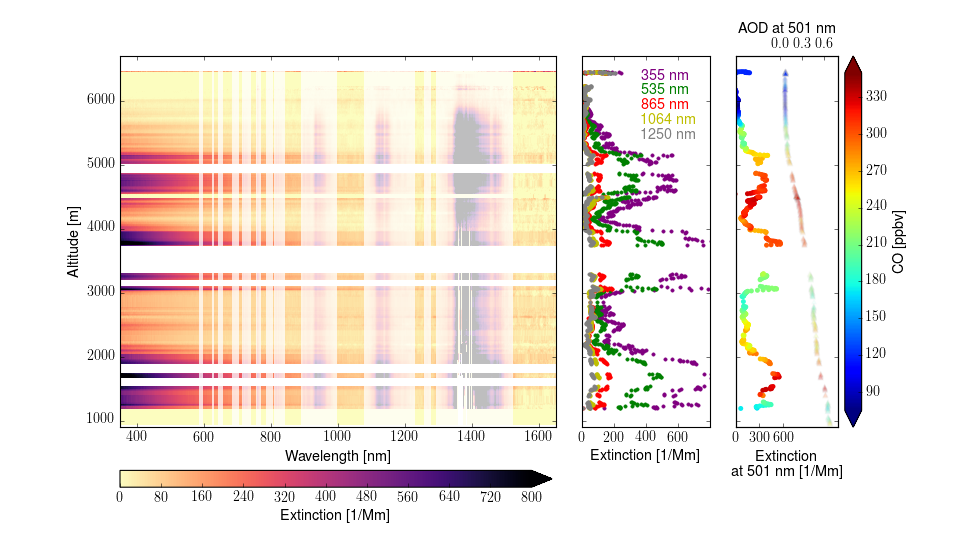

In [68]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot2grid((6,5),(0,0),colspan=3,rowspan=5)
cb = ax.pcolor(s['w'].flatten()*1000.0,alts,sext,
                   cmap='magma_r',vmin=0,vmax=800.0)

ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([900,6700])
ax.set_xlim([350,1650])

for rg in shade_rg:
    ax.axvspan(rg[0],rg[1],facecolor='white',alpha=0.75,edgecolor='None')

cbaxes=fig.add_axes([0.125, 0.13, 0.45, 0.03]) 
axc = plt.colorbar(cb,extend='max',orientation='horizontal',cax=cbaxes)
axc.set_label('Extinction [1/Mm]')

ax2 = plt.subplot2grid((6,5),(0,3),sharey=ax,rowspan=5)

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')
    
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')

leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)

ax3 = plt.subplot2grid((6,5),(0,4),sharey=ax,rowspan=5)
p = plt.scatter(s['ext'][it,i501],s['Alt'][it],c=co,vmin=75,vmax=350,cmap='jet',marker='o',edgecolor='None')
plt.xlabel('Extinction\nat 501 nm [1/Mm]')
#plt.ylabel('Altitude [m]')
plt.setp(ax3.get_yticklabels(), visible=False)
plt.xlim(0,1300)
plt.xticks([0,300,600])
plt.ylim(900,6700)

cb = plt.colorbar(p,extend='both')
cb.set_label('CO [ppbv]')

ax3t = ax3.twiny()
ax3t.scatter(s['tau_aero'][it,i501],s['Alt'][it],c=co,vmin=75,vmax=350,cmap='jet',marker='^',edgecolor='lightgrey',alpha=0.05)
ax3t.set_xlabel('AOD at 501 nm')
ax3t.set_xlim([-0.6,0.8])
ax3t.set_xticks([0,0.3,0.6])
#ax3t.xaxis.label.set_color('grey')
#ax3t.spines['top'].set_color('grey') 
#ax3t.set_title('AOD at 501 nm',color='lightgrey')
plt.ylim(900,6700)
#plt.suptitle(' ')

#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width, box.height*0.92])
#box2 = ax2.get_position()
#ax2.set_position([box2.x0, box2.y0, box2.width, box2.height*0.92])
#box3 = ax3.get_position()
#ax3.set_position([box3.x0, box3.y0, box3.width, box3.height*0.92])
#ax3t.set_position([box3.x0, box3.y0, box3.width, box3.height*0.92])

plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_empty_withCO_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


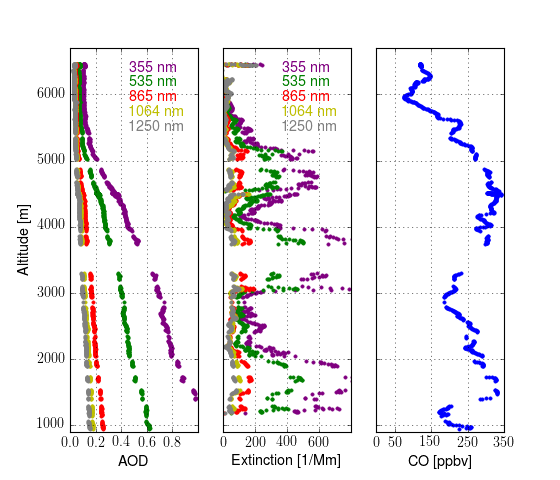

In [81]:
fig = plt.figure(figsize=(7,6))
ax2 = plt.subplot2grid((1,3),(0,1))

#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')

#axc = plt.colorbar(cb,extend='max')
#axc.set_label('Extinction [1/Mm]')
    
#plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot2grid((1,3),(0,0),sharey=ax2)
#ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.')
ax3.plot(s['tau_aero'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(s['tau_aero'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')
#ax3.plot(smooth(s['tau_aero'][it,i355],50,nan=False,old=True),s['Alt'][it],'-',color='k',label='Smoothed',alpha=0.6)

#ax3.plot(smooth(s['tau_aero'][it,i355],50,nan=False,old=True),s['Alt'][it],'-',color='purple',alpha=0.6)
#ax3.plot(smooth(s['tau_aero'][it,i532],50,nan=False,old=True),s['Alt'][it],'g-',alpha=0.6)
#ax3.plot(smooth(s['tau_aero'][it,i865],50,nan=False,old=True),s['Alt'][it],'r-',alpha=0.6)
#ax3.plot(smooth(s['tau_aero'][it,i1064],50,nan=False,old=True),s['Alt'][it],'-',color='y',alpha=0.6)
#ax3.plot(smooth(s['tau_aero'][it,i1250],50,nan=False,old=True),s['Alt'][it],'-',color='grey',alpha=0.6)


#axc = plt.colorbar(cb,extend='max')
#axc.set_label('AOD')
    
#plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([900,6700])
ax3.set_xlabel('AOD')
ax3.set_ylabel('Altitude [m]')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
ax4 = plt.subplot2grid((1,3),(0,2),sharey=ax2)
ax4.plot(co,s['Alt'][it],'.')
ax4.set_xlabel('CO [ppbv]')
ax4.set_xlim(0,350)
ax4.set_xticks([0,50,150,250,350])
ax4.set_ylim([900,6700])
plt.setp(ax4.get_yticklabels(), visible=False)
plt.grid()
    
plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_vs_AOD_vs_CO_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


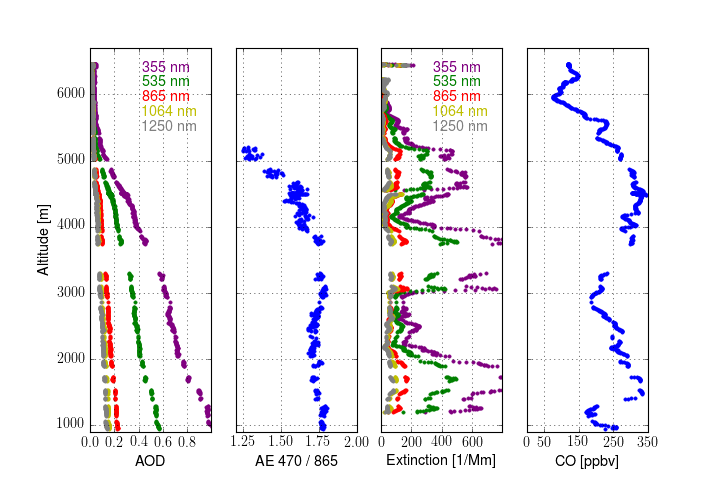

In [145]:
fig = plt.figure(figsize=(9,6))
ax2 = plt.subplot2grid((1,4),(0,2))

ax2.plot(s['ext'][it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax2.plot(s['ext'][it,i532],s['Alt'][it],'g.',label='535 nm')
ax2.plot(s['ext'][it,i865],s['Alt'][it],'r.',label='865 nm')
ax2.plot(s['ext'][it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax2.plot(s['ext'][it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')

ax2.set_xticks([0.0,200.0,400.0,600.0])
ax2.set_xlim([0.0,800.0])
ax2.set_ylim([900,6700])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot2grid((1,4),(0,0),sharey=ax2)
ax3.plot(aod[it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(aod[it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(aod[it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(aod[it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(aod[it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')


ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([900,6700])
ax3.set_xlabel('AOD')
ax3.set_ylabel('Altitude [m]')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((1,4),(0,1),sharey=ax2)
ita = s['tau_aero'][it,i532]>0.1
axa.plot(s['angs_470_865'][ita],s['Alt'][it][ita],'.')
axa.set_xlabel('AE 470 / 865')
axa.set_ylim([900,6700])
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([1.25,1.5,1.75,2.0])
plt.grid()

ax4 = plt.subplot2grid((1,4),(0,3),sharey=ax2)
ax4.plot(co,s['Alt'][it],'.')
ax4.set_xlabel('CO [ppbv]')
ax4.set_xlim(0,350)
ax4.set_xticks([0,50,150,250,350])
ax4.set_ylim([900,6700])
plt.setp(ax4.get_yticklabels(), visible=False)
plt.grid()
    
plt.savefig(fp+'plot_v2/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Add the in situ extinction

In [67]:
mrg,mrgh = lu.load_netcdf(fp+'data_other/merge/mrg1_P3_20160920_R21.nc',(('rh',35),('nwvl',49),('exttot',195),('scattot',195),('time',0),('utc',2),('time_bounds',1),('Alt',6),('Scat540RRwet',64),('Scattering_interpolated',73),('Abs',69)))

Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/merge/mrg1_P3_20160920_R21.nc
Outputting the Data subdatasets:
0: time
1: time_bounds
2: Start_UTC
3: Day_Of_Year
4: Latitude
5: Longitude
6: HAE_GPS_Altitude
7: Pressure_Altitude
8: Radar_Altitude
9: Ground_Speed
10: True_Air_Speed
11: Indicated_Air_Speed
12: Mach_Number
13: Vertical_Speed
14: True_Heading
15: Track_Angle
16: Drift_Angle
17: Pitch_Angle
18: Roll_Angle
19: Static_Air_Temp
20: Potential_Temp
21: Dew_Point
22: Total_Air_Temp
23: Static_Pressure
24: Cabin_Pressure
25: Wind_Speed
26: Wind_Direction
27: Solar_Zenith_Angle
28: Aircraft_Sun_Elevation
29: Sun_Azimuth
30: Aircraft_Sun_Azimuth
31: Mixing_Ratio
32: Part_Press_Water_Vapor
33: Sat_Vapor_Press_H2O
34: Sat_Vapor_Press_Ice
35: Relative_Humidity
36: WINDS_Pitch_deg
37: WINDS_Roll_deg
38: WINDS_Tstat_degC
39: WINDS_u_ms-1
40: WINDS_v_ms-1
41: WINDS_w_ms-1
42: WINDS_WSPD_ms-1
43: O3_ppbv
44: PTI_timestamp_start
45: PTI_timestamp_mid
46: PTI_timestamp_end
47:

In [68]:
mrgh['Scat540RRwet']

<type 'netCDF4._netCDF4.Variable'>
float64 Scat540RRwet(time)
    least_significant_digit: 1
    units: Mm^{-1}
    long_name: Scattering coefficient of air humidified to 80% RH from a Radiance Research M100 nephelometer for 540 nm light
    history: 2017-12-20 00:39:48 Merged using merge
    source: C:\data\source\HiGEAR\SCAT_P3_20160920_R1.ict
    missing_value: -9999.9
unlimited dimensions: 
current shape = (29151,)
filling on, default _FillValue of 9.96920996839e+36 used

In [69]:
mrgh['nwvl']

<type 'netCDF4._netCDF4.Variable'>
float64 nephelometerwavelength(nephelometerwavelength)
    long_name: TSI 3563 integrating nephelometer wavelength
    units: nm
    history: 2017-12-20 01:00:27 Merged using ORACLESmerge
    source: ORACLESmerge
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of 9.96920996839e+36 used

In [70]:
mrgh['rh']

<type 'netCDF4._netCDF4.Variable'>
float64 Relative_Humidity(time)
    least_significant_digit: 0
    units: percent
    missing_value: [-9999. -7777. -8888.]
    history: 2017-12-20 00:39:48 Copied using merge
    source: C:\data\source\AIRHOUSEKEEPING\Hskping_P3_20160920_R1.ict
unlimited dimensions: 
current shape = (29151,)
filling on, default _FillValue of 9.96920996839e+36 used

In [71]:
mrg['nwvl']

array([450., 550., 700.])

In [72]:
itm = (mrg['utc']/3600.0>profile[0]) & (mrg['utc']/3600.0<profile[1])

In [58]:
i450 = np.argmin(np.abs(s['w']*1000.0-450.0)) 
i550 = np.argmin(np.abs(s['w']*1000.0-550.0))
i540 = np.argmin(np.abs(s['w']*1000.0-540.0))
i700 = np.argmin(np.abs(s['w']*1000.0-700.0))

<IPython.core.display.Javascript object>


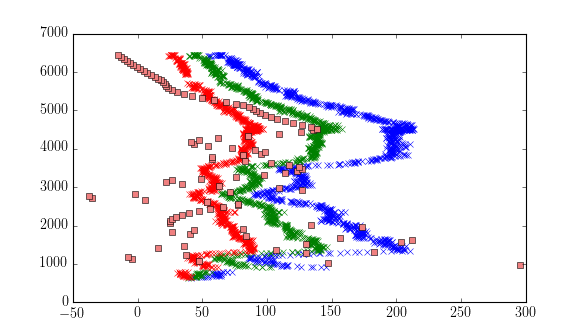

In [108]:
plt.figure()
plt.plot(mrg['exttot'][itm,0],mrg['Alt'][itm],'x',label='450 nm')
plt.plot(mrg['exttot'][itm,1],mrg['Alt'][itm],'x',label='550 nm')
plt.plot(mrg['exttot'][itm,2],mrg['Alt'][itm],'x',label='700 nm')


#plt.plot(s['ext'][it,i450]/2,s['Alt'][it],'.',color='purple',label='450 nm')
#plt.plot(s['ext'][it,i550]/2,s['Alt'][it],'g.',label='550 nm')
#plt.plot(s['ext'][it,i700]/2,s['Alt'][it],'r.',label='700 nm')

plt.plot(s['ext_spline'][i450,:]/2,altz,'s',color='lightcoral',label='450 nm')

In [73]:
len(mrg['exttot'][itm,0]),len(s['ext'][it,i450])

(1379, 740)

## Add the neph measurements

<IPython.core.display.Javascript object>


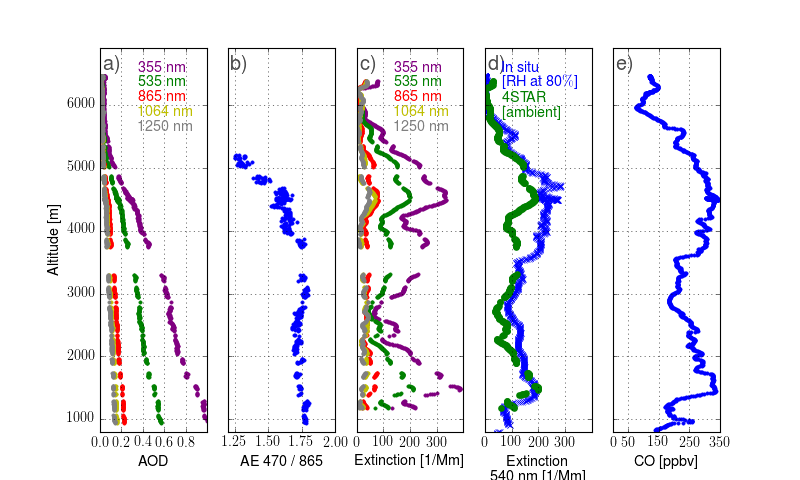

In [97]:
fig = plt.figure(figsize=(10,6))
ax2 = plt.subplot2grid((1,5),(0,2))

ax2.plot(s['xext'][:,i355],xalt,'.',color='purple',label='355 nm')
ax2.plot(s['xext'][:,i532],xalt,'g.',label='535 nm')
ax2.plot(s['xext'][:,i865],xalt,'r.',label='865 nm')
ax2.plot(s['xext'][:,i1064],xalt,'.',color='y',label='1064 nm')
ax2.plot(s['xext'][:,i1250],xalt,'.',color='grey',label='1250 nm')

ax2.set_xticks([0.0,100.0,200.0,300.0])
ax2.set_xlim([0.0,400.0])
ax2.set_ylim([800,6900])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot2grid((1,5),(0,0),sharey=ax2)
ax3.plot(aod[it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(aod[it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(aod[it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(aod[it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(aod[it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')


ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([800,6900])
ax3.set_xlabel('AOD')
ax3.set_ylabel('Altitude [m]')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((1,5),(0,1),sharey=ax2)
ita = s['tau_aero'][it,i532]>0.1
axa.plot(s['angs_470_865'][ita],s['Alt'][it][ita],'.')
axa.set_xlabel('AE 470 / 865')
axa.set_ylim([800,6900])
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([1.25,1.5,1.75,2.0])
plt.grid()

axn = plt.subplot2grid((1,5),(0,3),sharey=ax2)
#axn.plot(mrg['exttot'][itm,1],mrg['Alt'][itm],'x',label='In situ\n[dry]')
axn.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'x',label='In situ\n[RH at 80$\%$]')
axn.plot(s['xext'][:,i550],xalt,'o',label='4STAR\n[ambient]',markeredgewidth=0.0)
axn.set_xticks([0.0,100.0,200.0,300.0])
axn.set_xlim([0.0,400.0])
axn.set_xlabel('Extinction\n540 nm [1/Mm]')
axn.set_ylim([800,6900])
plt.setp(axn.get_yticklabels(), visible=False)
plt.grid()
leg = axn.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
#axns = axn.twiny()
#axns.plot(mrg['rh'][itm],mrg['Alt'][itm],'.',color='lightgrey',zorder=-10)
#axns.set_xlabel('RH [$\%$]')
#axns.set_xlim([0,100])
##axns.spines["bottom"].set_position(("axes", -0.15))
#axns.set_ylim([800,6900])
#axns.xaxis.label.set_color('lightgrey')
#axns.tick_params(axis='x', colors=('lightgrey'))
    
    
ax4 = plt.subplot2grid((1,5),(0,4),sharey=ax2)
ax4.plot(coppb,coalt,'.')
ax4.set_xlabel('CO [ppbv]')
ax4.set_xlim(0,350)
ax4.set_xticks([0,50,150,250,350])
ax4.set_ylim([800,6900])
plt.setp(ax4.get_yticklabels(), visible=False)
plt.grid()
        
pu.sub_note('a)',ax=ax3,dx=0.02)
pu.sub_note('b)',ax=axa,dx=0.02)
pu.sub_note('c)',ax=ax2,dx=0.02)
pu.sub_note('d)',ax=axn,dx=0.02)
pu.sub_note('e)',ax=ax4,dx=0.02)

plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph{dd}.png'.format(dd=dd),dpi=600,transparent=True)
#plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph{dd}.pdf'.format(dd=dd))
#plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph{dd}.eps'.format(dd=dd))

<IPython.core.display.Javascript object>


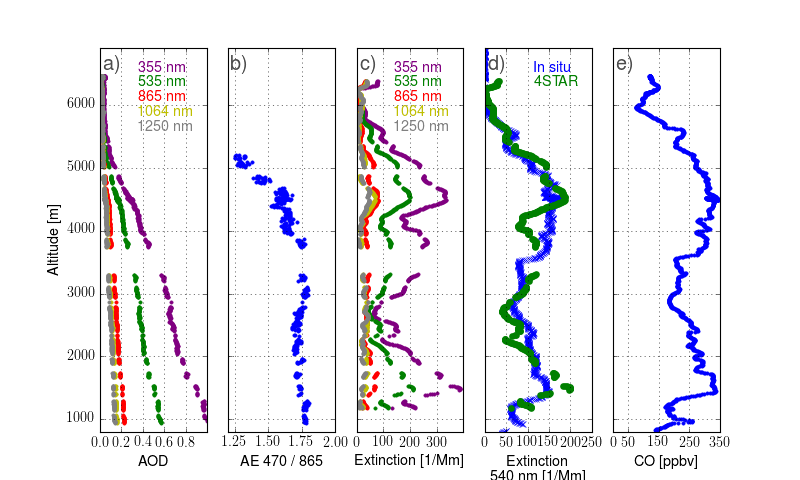

In [86]:
fig = plt.figure(figsize=(10,6))
ax2 = plt.subplot2grid((1,5),(0,2))

ax2.plot(s['xext'][:,i355],xalt,'.',color='purple',label='355 nm')
ax2.plot(s['xext'][:,i532],xalt,'g.',label='535 nm')
ax2.plot(s['xext'][:,i865],xalt,'r.',label='865 nm')
ax2.plot(s['xext'][:,i1064],xalt,'.',color='y',label='1064 nm')
ax2.plot(s['xext'][:,i1250],xalt,'.',color='grey',label='1250 nm')

ax2.set_xticks([0.0,100.0,200.0,300.0])
ax2.set_xlim([0.0,400.0])
ax2.set_ylim([800,6900])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot2grid((1,5),(0,0),sharey=ax2)
ax3.plot(aod[it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(aod[it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(aod[it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(aod[it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(aod[it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')


ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([800,6900])
ax3.set_xlabel('AOD')
ax3.set_ylabel('Altitude [m]')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((1,5),(0,1),sharey=ax2)
ita = s['tau_aero'][it,i532]>0.1
axa.plot(s['angs_470_865'][ita],s['Alt'][it][ita],'.')
axa.set_xlabel('AE 470 / 865')
axa.set_ylim([800,6900])
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([1.25,1.5,1.75,2.0])
plt.grid()

axn = plt.subplot2grid((1,5),(0,3),sharey=ax2)
#axn.plot(mrg['exttot'][itm,1],mrg['Alt'][itm],'x',label='In situ\n[dry]')
#axn.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'x',label='In situ\n[RH at 80$\%$]')
axn.plot(newext['Ext_540'],newext['ALT'],'x',label='In situ')
axn.plot(s['xext'][:,i550],xalt,'o',label='4STAR',markeredgewidth=0.0)
#axn.set_xticks([0.0,100.0,200.0,300.0])
axn.set_xlim([0.0,250.0])
axn.set_xlabel('Extinction\n540 nm [1/Mm]')
axn.set_ylim([800,6900])
plt.setp(axn.get_yticklabels(), visible=False)
plt.grid()
leg = axn.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
#axns = axn.twiny()
#axns.plot(mrg['rh'][itm],mrg['Alt'][itm],'.',color='lightgrey',zorder=-10)
#axns.set_xlabel('RH [$\%$]')
#axns.set_xlim([0,100])
##axns.spines["bottom"].set_position(("axes", -0.15))
#axns.set_ylim([800,6900])
#axns.xaxis.label.set_color('lightgrey')
#axns.tick_params(axis='x', colors=('lightgrey'))
    
    
ax4 = plt.subplot2grid((1,5),(0,4),sharey=ax2)
ax4.plot(coppb,coalt,'.')
ax4.set_xlabel('CO [ppbv]')
ax4.set_xlim(0,350)
ax4.set_xticks([0,50,150,250,350])
ax4.set_ylim([800,6900])
plt.setp(ax4.get_yticklabels(), visible=False)
plt.grid()
        
pu.sub_note('a)',ax=ax3,dx=0.02)
pu.sub_note('b)',ax=axa,dx=0.02)
pu.sub_note('c)',ax=ax2,dx=0.02)
pu.sub_note('d)',ax=axn,dx=0.02)
pu.sub_note('e)',ax=ax4,dx=0.02)

plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted{dd}.png'.format(dd=dd),dpi=600,transparent=True)
plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted{dd}.pdf'.format(dd=dd))
plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted{dd}.eps'.format(dd=dd))

In [79]:
matplotlib.rc('text.latex', preamble='\usepackage{color}')

<IPython.core.display.Javascript object>


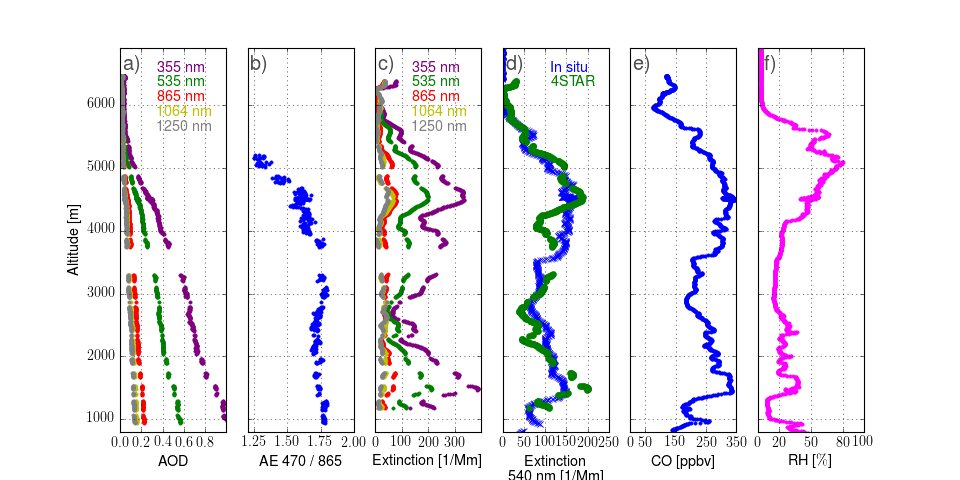

In [105]:
fig = plt.figure(figsize=(12,6))
ax2 = plt.subplot2grid((1,6),(0,2))

ax2.plot(s['xext'][:,i355],xalt,'.',color='purple',label='355 nm')
ax2.plot(s['xext'][:,i532],xalt,'g.',label='535 nm')
ax2.plot(s['xext'][:,i865],xalt,'r.',label='865 nm')
ax2.plot(s['xext'][:,i1064],xalt,'.',color='y',label='1064 nm')
ax2.plot(s['xext'][:,i1250],xalt,'.',color='grey',label='1250 nm')

ax2.set_xticks([0.0,100.0,200.0,300.0])
ax2.set_xlim([0.0,400.0])
ax2.set_ylim([800,6900])
ax2.set_xlabel('Extinction [1/Mm]')
plt.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.setp(ax2.get_yticklabels(), visible=False)

ax3 = plt.subplot2grid((1,6),(0,0),sharey=ax2)
ax3.plot(aod[it,i355],s['Alt'][it],'.',color='purple',label='355 nm')
ax3.plot(aod[it,i532],s['Alt'][it],'g.',label='535 nm')
ax3.plot(aod[it,i865],s['Alt'][it],'r.',label='865 nm')
ax3.plot(aod[it,i1064],s['Alt'][it],'.',color='y',label='1064 nm')
ax3.plot(aod[it,i1250],s['Alt'][it],'.',color='grey',label='1250 nm')


ax3.set_xticks([0.0,0.200,0.400,0.600,0.8])
ax3.set_xlim([0.0,1.000])
ax3.set_ylim([800,6900])
ax3.set_xlabel('AOD')
ax3.set_ylabel('Altitude [m]')
plt.grid()

leg = ax3.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((1,6),(0,1),sharey=ax2)
ita = s['tau_aero'][it,i532]>0.1
axa.plot(s['angs_470_865'][ita],s['Alt'][it][ita],'.')
axa.set_xlabel('AE 470 / 865')
axa.set_ylim([800,6900])
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([1.25,1.5,1.75,2.0])
plt.grid()

axn = plt.subplot2grid((1,6),(0,3),sharey=ax2)
#axn.plot(mrg['exttot'][itm,1],mrg['Alt'][itm],'x',label='In situ\n[dry]')
#axn.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'x',label='In situ\n[RH at 80$\%$]')
axn.plot(newext['Ext_540'],newext['ALT'],'x',label='In situ')
axn.plot(s['xext'][:,i550],xalt,'o',label='4STAR',markeredgewidth=0.0)
#axn.set_xticks([0.0,100.0,200.0,300.0])
axn.set_xlim([0.0,250.0])
axn.set_xlabel('Extinction\n540 nm [1/Mm]')
axn.set_ylim([800,6900])
plt.setp(axn.get_yticklabels(), visible=False)
plt.grid()
leg = axn.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
#axns = axn.twiny()
#axns.plot(mrg['rh'][itm],mrg['Alt'][itm],'.',color='lightgrey',zorder=-10)
#axns.set_xlabel('RH [$\%$]')
#axns.set_xlim([0,100])
##axns.spines["bottom"].set_position(("axes", -0.15))
#axns.set_ylim([800,6900])
#axns.xaxis.label.set_color('lightgrey')
#axns.tick_params(axis='x', colors=('lightgrey'))
    
    
ax4 = plt.subplot2grid((1,6),(0,4),sharey=ax2)
ax4.plot(coppb,coalt,'.',label='CO')
#ax4.plot(newext['Relative_Humidity'],newext['ALT'],'.',label='RH',color='magenta')
ax4.set_xlabel('CO [ppbv]') #, RH [$\%$]
ax4.set_xlim(0,350)
ax4.set_xticks([0,50,150,250,350])
ax4.set_ylim([800,6900])
#leg2 = ax4.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
#for line,text in zip(leg2.get_lines(), leg2.get_texts()):
#    text.set_color(line.get_color())
#    line.set_linewidth(5.0)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.grid()

ax5 = plt.subplot2grid((1,6),(0,5),sharey=ax2)
#ax5.plot(coppb,coalt,'.',label='CO')
ax5.plot(newext['Relative_Humidity'],newext['ALT'],'.',label='RH',color='magenta')
ax5.set_xlabel('RH [$\%$]') #, 
ax5.set_xlim(0,100)
ax5.set_xticks([0,20,50,80,100])
ax5.set_ylim([800,6900])
#leg2 = ax4.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
#for line,text in zip(leg2.get_lines(), leg2.get_texts()):
#    text.set_color(line.get_color())
#    line.set_linewidth(5.0)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.grid()

        
pu.sub_note('a)',ax=ax3,dx=0.02)
pu.sub_note('b)',ax=axa,dx=0.02)
pu.sub_note('c)',ax=ax2,dx=0.02)
pu.sub_note('d)',ax=axn,dx=0.02)
pu.sub_note('e)',ax=ax4,dx=0.02)
pu.sub_note('f)',ax=ax5,dx=0.05)

plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted_RH{dd}.png'.format(dd=dd),dpi=600,transparent=True)
plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted_RH{dd}.pdf'.format(dd=dd))
plt.savefig(fp+'plot_v3/Ext_Alt_profile_derivative_vs_AOD_vs_CO_vs_AE_neph_adjusted_RH{dd}.eps'.format(dd=dd))

## Load the extinction from RH adjusted RRnephs

In [74]:
fpo

u'/mnt/c/Users/sleblanc/Research/ORACLES/data_other/'

In [75]:
new_ext = np.genfromtxt(fpo+'Scat20160920profile.csv',delimiter=',',filling_values=np.nan,names=True)

In [76]:
newext = lu.recarray_to_dict(new_ext)

In [77]:
new_ext.dtype.names

('utc_secs',
 'ALT',
 'Latitude',
 'Longitude',
 'RH_RRdry',
 'RH_RRwet',
 'Relative_Humidity',
 'scatgamma',
 'Scat540RRdry',
 'Scat540RRdry_ATP',
 'Scat540RRdry_ATPRH',
 'Scat540RRwet',
 'Scat540RRwet_ATP',
 'RH_TSI1',
 'Ext_540')

In [78]:
newext['utc'] = newext['utc_secs']/3600.0

## plot out only the profile insitu extinction coefficient

<IPython.core.display.Javascript object>


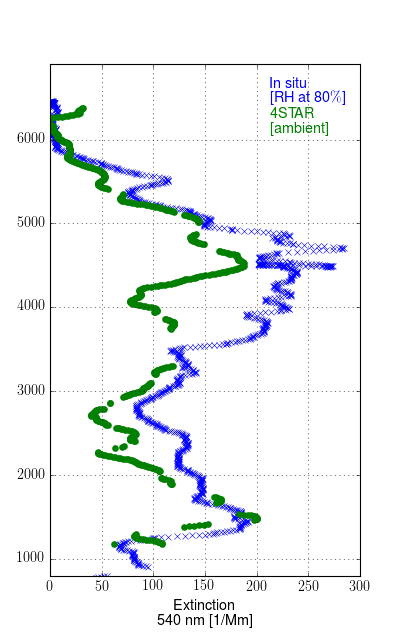

In [130]:
fig = plt.figure(figsize=(5,8))
axn = fig.add_subplot(111)
axn.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'x',label='In situ\n[RH at 80$\%$]')
axn.plot(s['xext'][:,i550],xalt,'o',label='4STAR\n[ambient]',markeredgewidth=0.0)
axn.set_xlim([0.0,300.0])
axn.set_xlabel('Extinction\n540 nm [1/Mm]')
axn.set_ylim([800,6900])
#plt.setp(axn.get_yticklabels(), visible=False)
plt.grid()
leg = axn.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)

<IPython.core.display.Javascript object>


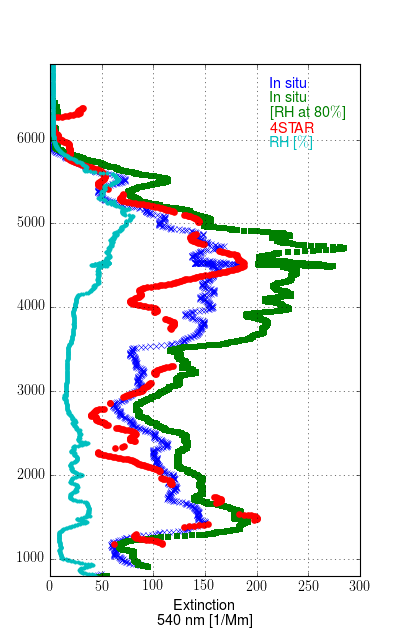

In [152]:
fig = plt.figure(figsize=(5,8))
axn = fig.add_subplot(111)
#
axn.plot(newext['Ext_540'],newext['ALT'],'x',label='In situ')
axn.plot(mrg['Abs'][itm,1]+mrg['Scat540RRwet'][itm],mrg['Alt'][itm],'s',label='In situ\n[RH at 80$\%$]',markeredgewidth=0.0)
axn.plot(s['xext'][:,i550],xalt,'o',label='4STAR',markeredgewidth=0.0)
axn.plot(newext['Relative_Humidity'],newext['ALT'],'.',label='RH [$\%$]')
axn.set_xlim([0.0,300.0])
axn.set_xlabel('Extinction\n540 nm [1/Mm]')
axn.set_ylim([800,6900])
#plt.setp(axn.get_yticklabels(), visible=False)
plt.grid()
leg = axn.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2,labelspacing=0.1)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
plt.savefig(fp+'plot_v3/Ext_Alt_profile_4STAR_insitu_adjustedRH_{dd}.png'.format(dd=dd),dpi=600,transparent=True)


# Save to file

In [67]:
import hdf5storage as hs

In [66]:
saves = {'tau_aero':s['tau_aero'][it,:],'extinction':s['ext'][it,:],
         'Altitude':s['Alt'][it],'UTC':s['utc'][it],'Profile_time_bounds':profile,
         'CO_ppbv':co,'wvl':s['w']*1000.0}

In [68]:
hs.savemat(fp+'AOD_profile_{}.mat'.format(dd),saves)

# Now load the HSRL data and plot that

In [467]:
import hdf5storage as hs

In [468]:
import load_utils as lu

In [469]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [472]:
hsrl = lu.load_hdf(fp+'data_other/HSRL2_ER2_20160920_R4.h5')

Outputting the Data subdatasets:
0: [2479x1392] //DataProducts/1064_aer_dep (64-bit floating-point)
1: [2479x1392] //DataProducts/1064_bsc (64-bit floating-point)
2: [2479x1392] //DataProducts/1064_bsc_Sa (64-bit floating-point)
3: [2479x1392] //DataProducts/1064_bsc_cloud_screened (64-bit floating-point)
4: [2479x1392] //DataProducts/1064_bsr (64-bit floating-point)
5: [2479x1392] //DataProducts/1064_bsr_cloud_screened (64-bit floating-point)
6: [2479x1392] //DataProducts/1064_dep (64-bit floating-point)
7: [2479x1392] //DataProducts/1064_ext (64-bit floating-point)
8: [2479x1392] //DataProducts/1064_total_attn_bsc (64-bit floating-point)
9: [2479x1] //DataProducts/355_AOT_above_cloud (64-bit floating-point)
10: [2479x1] //DataProducts/355_AOT_hi (64-bit floating-point)
11: [2479x1392] //DataProducts/355_AOT_hi_col (64-bit floating-point)
12: [2479x1392] //DataProducts/355_Sa (64-bit floating-point)
13: [2479x1392] //DataProducts/355_aer_dep (64-bit floating-point)
14: [2479x1392] //D

In [473]:
val = (('AOTcum_355',11),('AOTcum_532',24),('ext_1064',7),('Alt',36),('Lat',106),('Lon',107),('GPS_alt',105),('time',108))

In [477]:
hsrl,hsrl_head = lu.load_hdf(fp+'data_other/HSRL2_ER2_20160920_R4.h5',values=val)

Outputting the Data subdatasets:
0: [2479x1392] //DataProducts/1064_aer_dep (64-bit floating-point)
1: [2479x1392] //DataProducts/1064_bsc (64-bit floating-point)
2: [2479x1392] //DataProducts/1064_bsc_Sa (64-bit floating-point)
3: [2479x1392] //DataProducts/1064_bsc_cloud_screened (64-bit floating-point)
4: [2479x1392] //DataProducts/1064_bsr (64-bit floating-point)
5: [2479x1392] //DataProducts/1064_bsr_cloud_screened (64-bit floating-point)
6: [2479x1392] //DataProducts/1064_dep (64-bit floating-point)
7: [2479x1392] //DataProducts/1064_ext (64-bit floating-point)
8: [2479x1392] //DataProducts/1064_total_attn_bsc (64-bit floating-point)
9: [2479x1] //DataProducts/355_AOT_above_cloud (64-bit floating-point)
10: [2479x1] //DataProducts/355_AOT_hi (64-bit floating-point)
11: [2479x1392] //DataProducts/355_AOT_hi_col (64-bit floating-point)
12: [2479x1392] //DataProducts/355_Sa (64-bit floating-point)
13: [2479x1392] //DataProducts/355_aer_dep (64-bit floating-point)
14: [2479x1392] //D

Running through data values: [########################################]100% -- Done! 
['AOTcum_355', 'time', 'Lon', 'ext_1064', 'AOTcum_532', 'GPS_alt', 'Lat', 'Alt']


In [479]:
hsrl['time']

array([[  8.10861111],
       [  8.11166673],
       [  8.11444444],
       ..., 
       [ 15.02263892],
       [ 15.02541672],
       [ 15.02819452]])

In [517]:
ih = np.argmin(abs(hsrl['time']-11.95))

In [484]:
ih

1347

In [497]:
hsrl['Alt']

array([[  -300.    ,   -285.0104,   -270.0208, ...,  20520.5544,
         20535.544 ,  20550.5336]])

## Now plot the vertical HSRL AOT profile corresponding to 4STAR's measurement

<IPython.core.display.Javascript object>


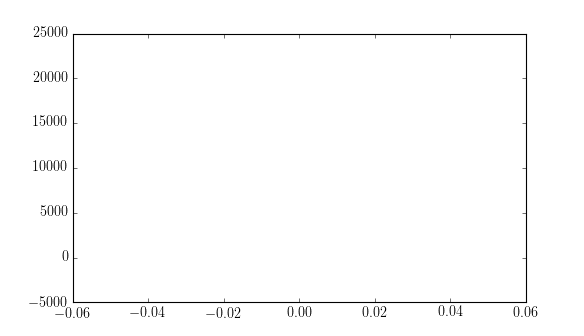

 ...]

In [495]:
plt.figure()
plt.plot(hsrl['Alt'])

<IPython.core.display.Javascript object>


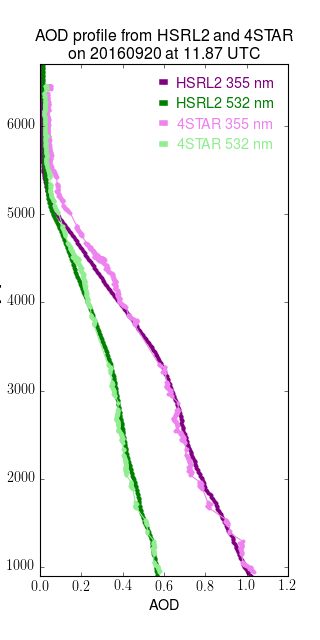

In [519]:
plt.figure(figsize=(4,8))
plt.plot(hsrl['AOTcum_355'][ih,:],hsrl['Alt'].flatten(),'.-',color='purple',label='HSRL2 355 nm')
plt.plot(hsrl['AOTcum_532'][ih,:],hsrl['Alt'].flatten(),'.-',color='g',label='HSRL2 532 nm')

plt.plot(s['tau_aero'][it,i355]-0.065,s['Alt'][it],'.-',color='violet',label='4STAR 355 nm')
plt.plot(s['tau_aero'][it,i532]-0.045,s['Alt'][it],'.-',color='lightgreen',label='4STAR 532 nm')

plt.ylim([900,6700])
plt.xlim([0,tau_max])
plt.xlabel('AOD')
plt.ylabel('Altitude [m]')
leg = plt.legend(frameon=False,loc=1,numpoints=1,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
plt.title('AOD profile from HSRL2 and 4STAR\n on {} at 11.87 UTC'.format(dd))

plt.savefig(fp+'plot/AOD_Alt_profile_vs_HSRL_{}.png'.format(dd),dpi=600,transparent=True)